Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame, shift_frame):
    dataX, dataY = [], []
    for i in range(max(0,look_frame-shift_frame), min(len(dataset), len(dataset) - look_frame - shift_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(shift_frame+i-look_frame):(shift_frame+i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest, shift_frame):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame, shift_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST, shift_frame):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], shift_frame)
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
import itertools

In [11]:
WinShift = [-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60]
ModelType = 'GRU'

In [12]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

In [13]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 15]), columns=['VALID','TEST']+WinShift)
df_LOSS = pandas.DataFrame(numpy.zeros([20, 15]), columns=['VALID','TEST']+WinShift)
df_ACC = pandas.DataFrame(numpy.zeros([20, 15]), columns=['VALID','TEST']+WinShift)

-60
TEST
Mouse 1
(197175, 50, 31)


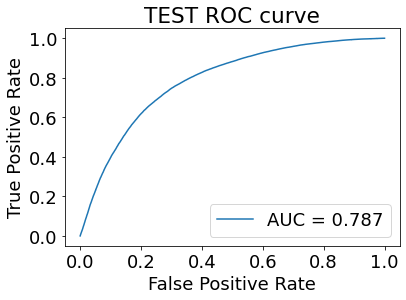

AUC: 0.787
Optimal threshold: 0.573
197175/197175 [==============================] - 45s 229us/sample - loss: 0.5997 - acc: 0.6963
-50
TEST
Mouse 1
(197285, 50, 31)


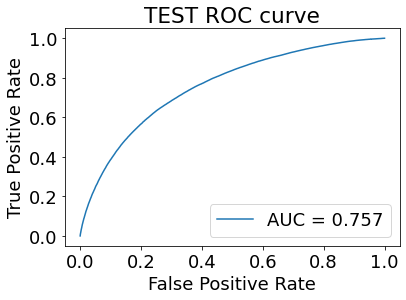

AUC: 0.757
Optimal threshold: 0.339
197285/197285 [==============================] - 45s 228us/sample - loss: 0.5707 - acc: 0.7182
-40
TEST
Mouse 1
(197395, 50, 31)


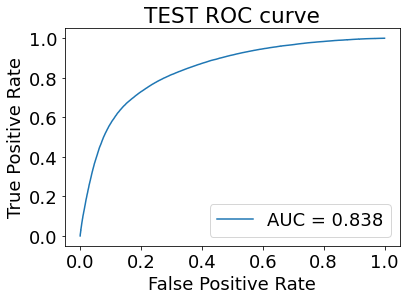

AUC: 0.838
Optimal threshold: 0.350
197395/197395 [==============================] - 45s 227us/sample - loss: 0.4866 - acc: 0.7836
-30
TEST
Mouse 1
(197505, 50, 31)


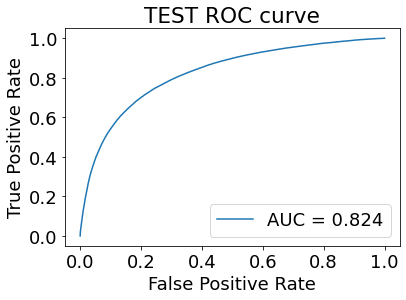

AUC: 0.824
Optimal threshold: 0.266
197505/197505 [==============================] - 45s 227us/sample - loss: 0.5085 - acc: 0.7674
-20
TEST
Mouse 1
(197615, 50, 31)


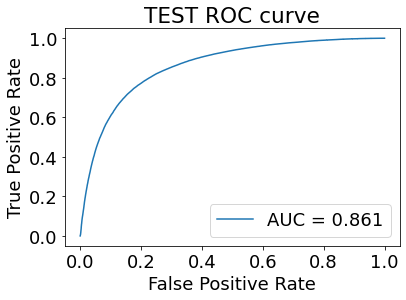

AUC: 0.861
Optimal threshold: 0.245
197615/197615 [==============================] - 45s 230us/sample - loss: 0.4763 - acc: 0.7888
-10
TEST
Mouse 1
(197670, 50, 31)


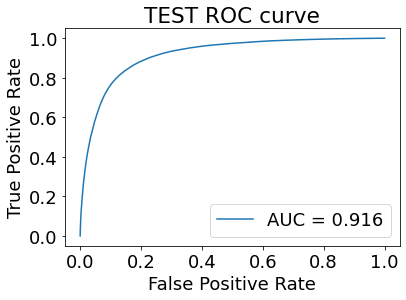

AUC: 0.916
Optimal threshold: 0.114
197670/197670 [==============================] - 46s 231us/sample - loss: 0.4476 - acc: 0.8125
0
TEST
Mouse 1
(197670, 50, 31)


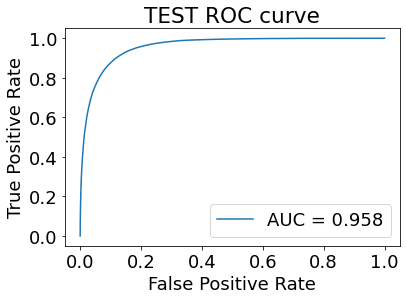

AUC: 0.958
Optimal threshold: 0.316
197670/197670 [==============================] - 46s 231us/sample - loss: 0.2553 - acc: 0.8914
10
TEST
Mouse 1
(197670, 50, 31)


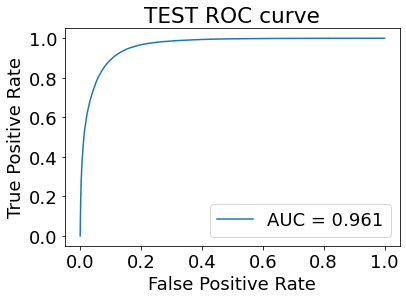

AUC: 0.961
Optimal threshold: 0.146
197670/197670 [==============================] - 45s 229us/sample - loss: 0.2763 - acc: 0.8813
20
TEST
Mouse 1
(197615, 50, 31)


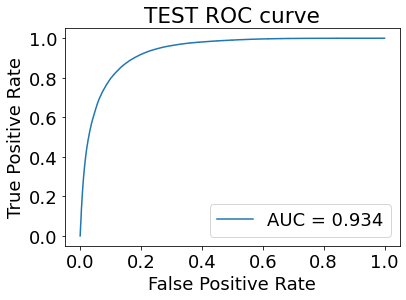

AUC: 0.934
Optimal threshold: 0.333
197615/197615 [==============================] - 46s 232us/sample - loss: 0.3198 - acc: 0.8625
30
TEST
Mouse 1
(197505, 50, 31)


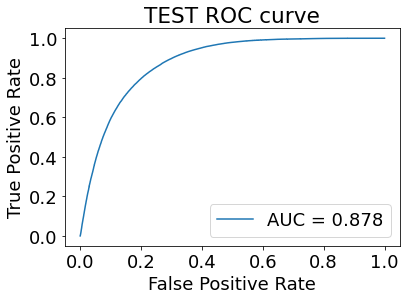

AUC: 0.878
Optimal threshold: 0.407
197505/197505 [==============================] - 46s 233us/sample - loss: 0.4680 - acc: 0.7977
40
TEST
Mouse 1
(197395, 50, 31)


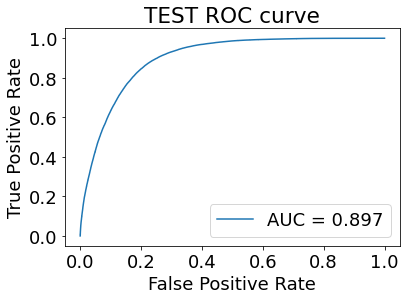

AUC: 0.897
Optimal threshold: 0.557
197395/197395 [==============================] - 46s 233us/sample - loss: 0.4673 - acc: 0.8042
50
TEST
Mouse 1
(197285, 50, 31)


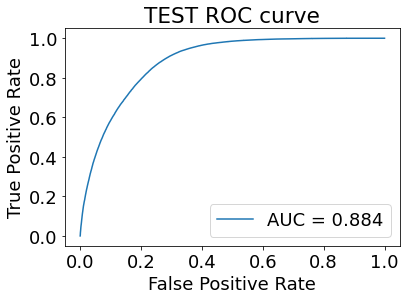

AUC: 0.884
Optimal threshold: 0.322
197285/197285 [==============================] - 45s 230us/sample - loss: 0.4444 - acc: 0.7971
60
TEST
Mouse 1
(197175, 50, 31)


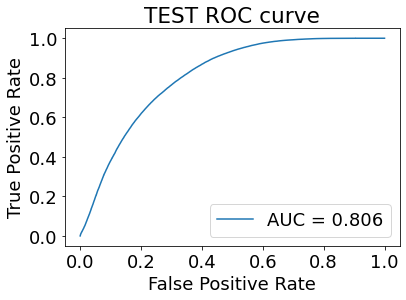

AUC: 0.806
Optimal threshold: 0.774
197175/197175 [==============================] - 46s 234us/sample - loss: 0.8756 - acc: 0.6335
-60
TEST
Mouse 1
(197175, 50, 31)


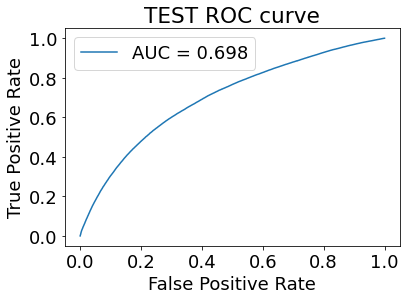

AUC: 0.698
Optimal threshold: 0.483
197175/197175 [==============================] - 46s 236us/sample - loss: 0.6276 - acc: 0.6699
-50
TEST
Mouse 1
(197285, 50, 31)


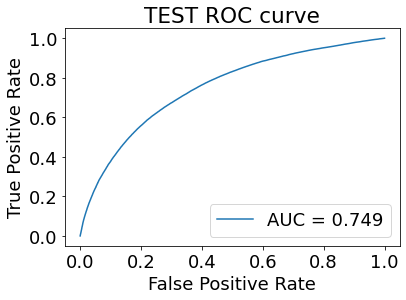

AUC: 0.749
Optimal threshold: 0.311
197285/197285 [==============================] - 47s 236us/sample - loss: 0.5823 - acc: 0.7145
-40
TEST
Mouse 1
(197395, 50, 31)


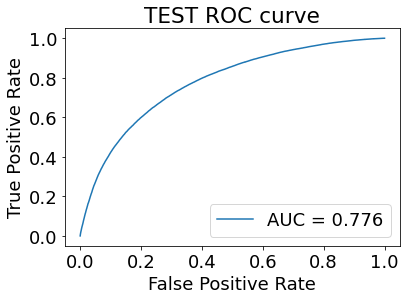

AUC: 0.776
Optimal threshold: 0.225
197395/197395 [==============================] - 47s 237us/sample - loss: 0.5820 - acc: 0.7218
-30
TEST
Mouse 1
(197505, 50, 31)


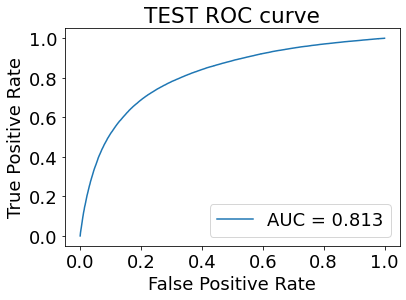

AUC: 0.813
Optimal threshold: 0.264
197505/197505 [==============================] - 46s 234us/sample - loss: 0.5309 - acc: 0.7540
-20
TEST
Mouse 1
(197615, 50, 31)


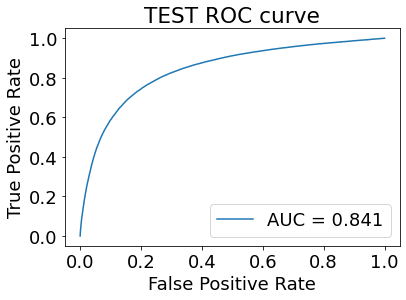

AUC: 0.841
Optimal threshold: 0.189
197615/197615 [==============================] - 47s 238us/sample - loss: 0.5361 - acc: 0.7719
-10
TEST
Mouse 1
(197670, 50, 31)


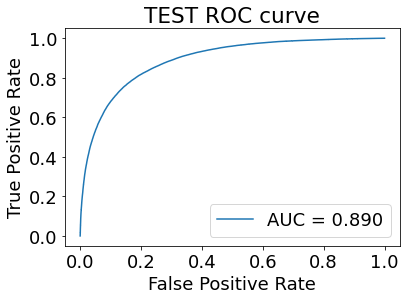

AUC: 0.890
Optimal threshold: 0.138
197670/197670 [==============================] - 45s 230us/sample - loss: 0.4825 - acc: 0.8062
0
TEST
Mouse 1
(197670, 50, 31)


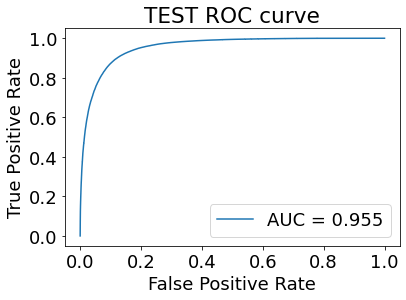

AUC: 0.955
Optimal threshold: 0.109
197670/197670 [==============================] - 47s 239us/sample - loss: 0.3364 - acc: 0.8531
10
TEST
Mouse 1
(197670, 50, 31)


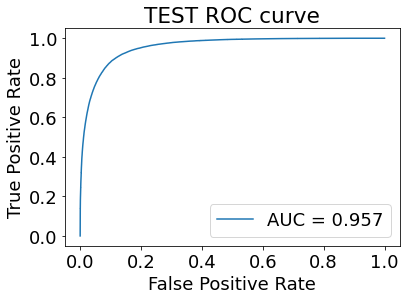

AUC: 0.957
Optimal threshold: 0.122
197670/197670 [==============================] - 47s 238us/sample - loss: 0.3133 - acc: 0.8667
20
TEST
Mouse 1
(197615, 50, 31)


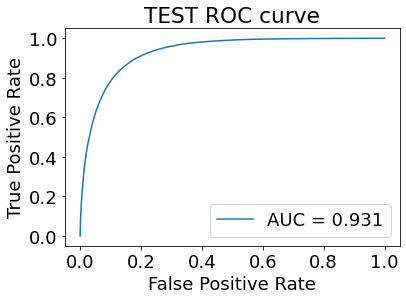

AUC: 0.931
Optimal threshold: 0.175
197615/197615 [==============================] - 47s 240us/sample - loss: 0.3537 - acc: 0.8496
30
TEST
Mouse 1
(197505, 50, 31)


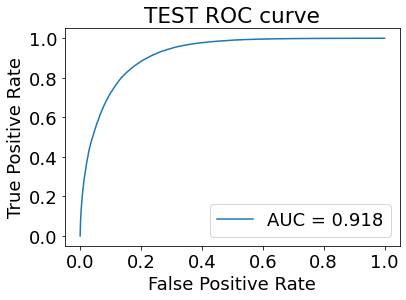

AUC: 0.918
Optimal threshold: 0.181
197505/197505 [==============================] - 47s 237us/sample - loss: 0.3813 - acc: 0.8368
40
TEST
Mouse 1
(197395, 50, 31)


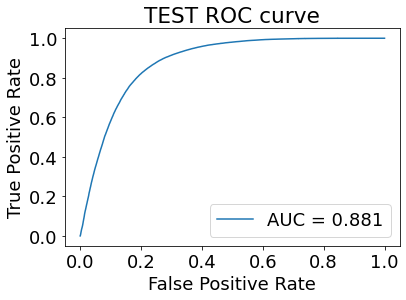

AUC: 0.881
Optimal threshold: 0.260
197395/197395 [==============================] - 47s 238us/sample - loss: 0.4456 - acc: 0.8055
50
TEST
Mouse 1
(197285, 50, 31)


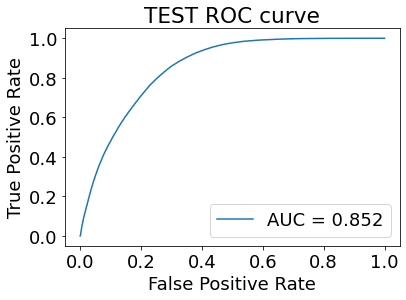

AUC: 0.852
Optimal threshold: 0.697
197285/197285 [==============================] - 47s 239us/sample - loss: 0.6748 - acc: 0.7330
60
TEST
Mouse 1
(197175, 50, 31)


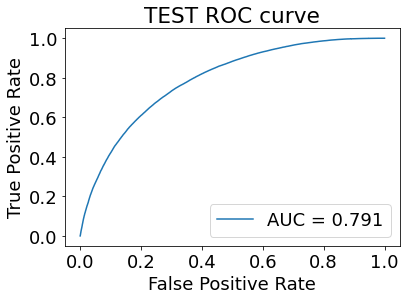

AUC: 0.791
Optimal threshold: 0.741
197175/197175 [==============================] - 47s 239us/sample - loss: 0.7590 - acc: 0.6282
-60
TEST
Mouse 1
(197175, 50, 31)


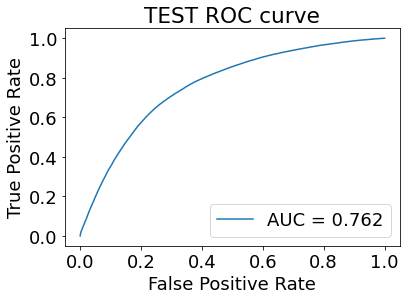

AUC: 0.762
Optimal threshold: 0.359
197175/197175 [==============================] - 44s 226us/sample - loss: 0.5840 - acc: 0.7175
-50
TEST
Mouse 1
(197285, 50, 31)


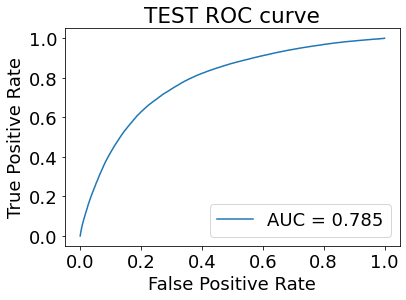

AUC: 0.785
Optimal threshold: 0.337
197285/197285 [==============================] - 48s 245us/sample - loss: 0.5394 - acc: 0.7361
-40
TEST
Mouse 1
(197395, 50, 31)


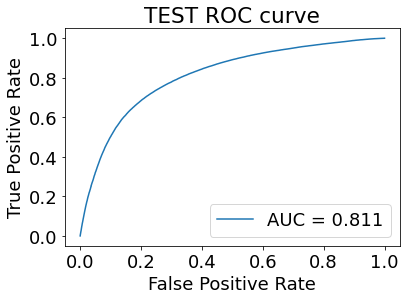

AUC: 0.811
Optimal threshold: 0.347
197395/197395 [==============================] - 49s 246us/sample - loss: 0.5137 - acc: 0.7635
-30
TEST
Mouse 1
(197505, 50, 31)


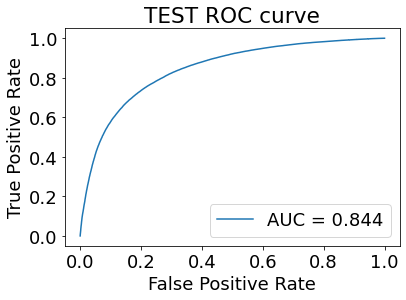

AUC: 0.844
Optimal threshold: 0.229
197505/197505 [==============================] - 49s 246us/sample - loss: 0.5023 - acc: 0.7728
-20
TEST
Mouse 1
(197615, 50, 31)


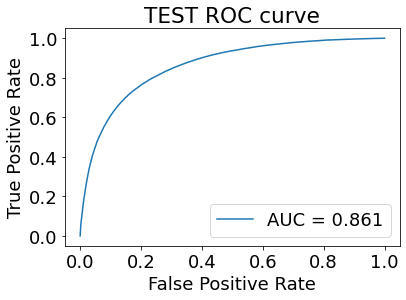

AUC: 0.861
Optimal threshold: 0.327
197615/197615 [==============================] - 48s 244us/sample - loss: 0.4588 - acc: 0.7955
-10
TEST
Mouse 1
(197670, 50, 31)


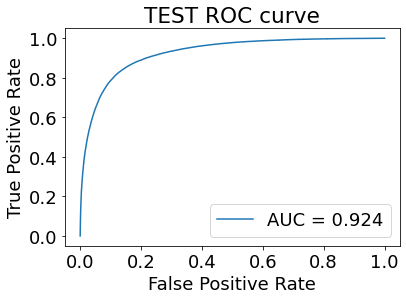

AUC: 0.924
Optimal threshold: 0.125
197670/197670 [==============================] - 48s 245us/sample - loss: 0.4131 - acc: 0.8361
0
TEST
Mouse 1
(197670, 50, 31)


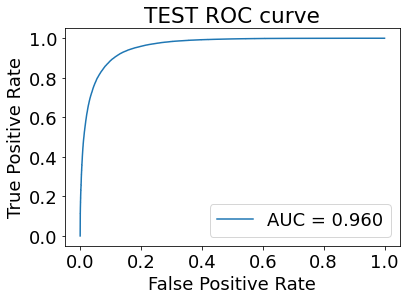

AUC: 0.960
Optimal threshold: 0.104
197670/197670 [==============================] - 50s 251us/sample - loss: 0.3264 - acc: 0.8559
10
TEST
Mouse 1
(197670, 50, 31)


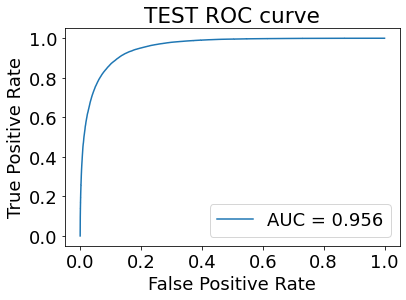

AUC: 0.956
Optimal threshold: 0.160
197670/197670 [==============================] - 49s 250us/sample - loss: 0.2955 - acc: 0.8696
20
TEST
Mouse 1
(197615, 50, 31)


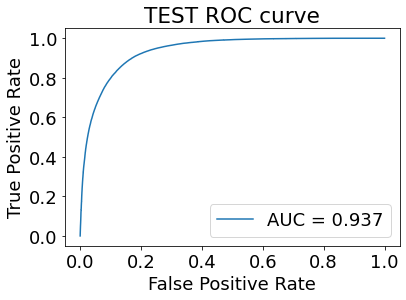

AUC: 0.937
Optimal threshold: 0.234
197615/197615 [==============================] - 47s 236us/sample - loss: 0.3229 - acc: 0.8613
30
TEST
Mouse 1
(197505, 50, 31)


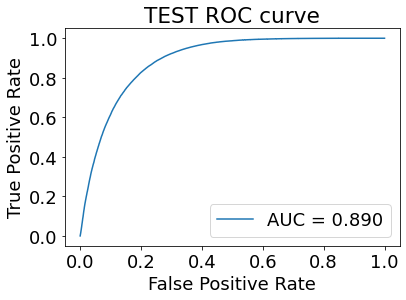

AUC: 0.890
Optimal threshold: 0.252
197505/197505 [==============================] - 49s 247us/sample - loss: 0.4321 - acc: 0.8115
40
TEST
Mouse 1
(197395, 50, 31)


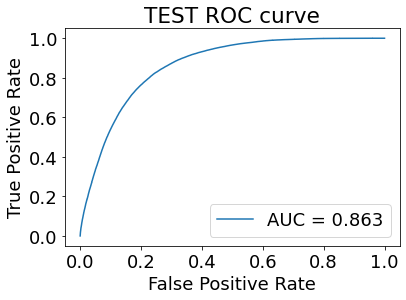

AUC: 0.863
Optimal threshold: 0.464
197395/197395 [==============================] - 49s 249us/sample - loss: 0.4906 - acc: 0.7824
50
TEST
Mouse 1
(197285, 50, 31)


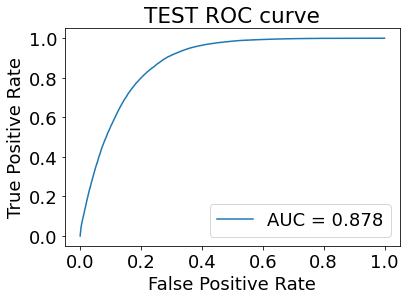

AUC: 0.878
Optimal threshold: 0.560
197285/197285 [==============================] - 49s 251us/sample - loss: 0.5389 - acc: 0.7812
60
TEST
Mouse 1
(197175, 50, 31)


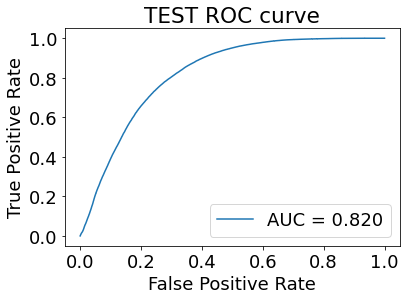

AUC: 0.820
Optimal threshold: 0.636
197175/197175 [==============================] - 49s 248us/sample - loss: 0.7028 - acc: 0.7016
-60
TEST
Mouse 1
(197175, 50, 31)


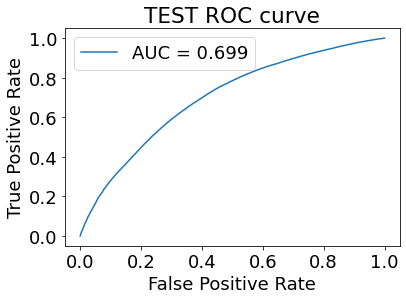

AUC: 0.699
Optimal threshold: 0.575
197175/197175 [==============================] - 49s 249us/sample - loss: 0.7087 - acc: 0.6061
-50
TEST
Mouse 1
(197285, 50, 31)


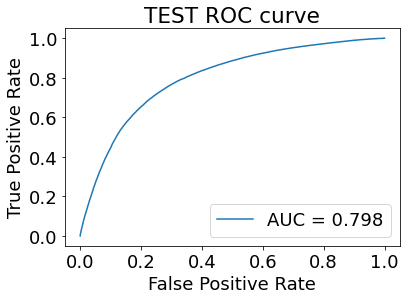

AUC: 0.798
Optimal threshold: 0.300
197285/197285 [==============================] - 50s 252us/sample - loss: 0.5349 - acc: 0.7485
-40
TEST
Mouse 1
(197395, 50, 31)


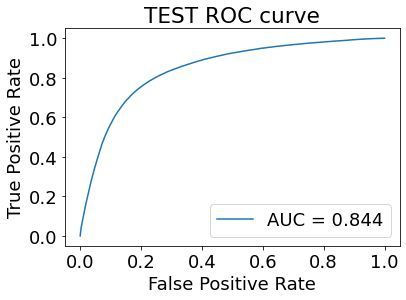

AUC: 0.844
Optimal threshold: 0.268
197395/197395 [==============================] - 50s 252us/sample - loss: 0.4857 - acc: 0.7802
-30
TEST
Mouse 1
(197505, 50, 31)


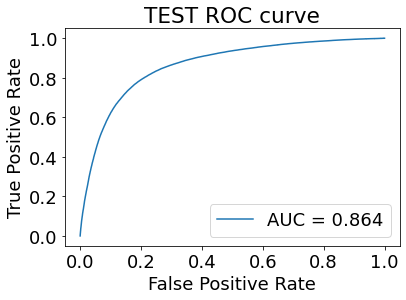

AUC: 0.864
Optimal threshold: 0.345
197505/197505 [==============================] - 49s 248us/sample - loss: 0.4458 - acc: 0.8033
-20
TEST
Mouse 1
(197615, 50, 31)


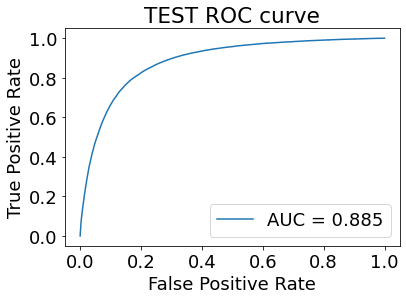

AUC: 0.885
Optimal threshold: 0.172
197615/197615 [==============================] - 50s 254us/sample - loss: 0.4692 - acc: 0.7851
-10
TEST
Mouse 1
(197670, 50, 31)


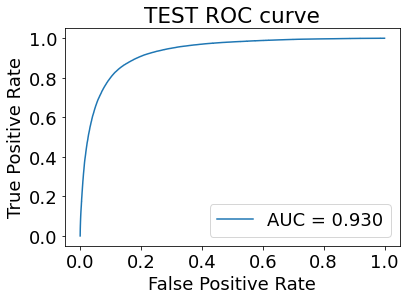

AUC: 0.930
Optimal threshold: 0.072
197670/197670 [==============================] - 50s 254us/sample - loss: 0.4741 - acc: 0.8088
0
TEST
Mouse 1
(197670, 50, 31)


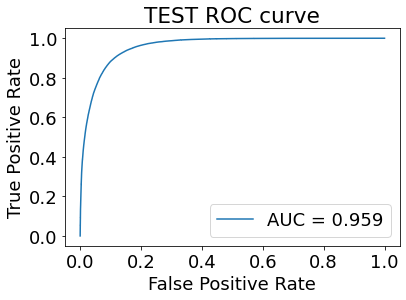

AUC: 0.959
Optimal threshold: 0.073
197670/197670 [==============================] - 51s 258us/sample - loss: 0.3449 - acc: 0.8524
10
TEST
Mouse 1
(197670, 50, 31)


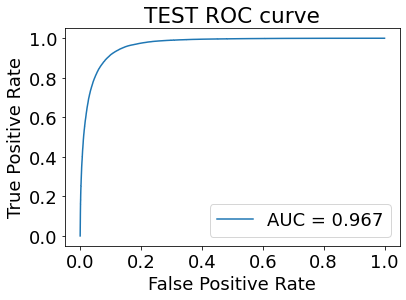

AUC: 0.967
Optimal threshold: 0.226
197670/197670 [==============================] - 51s 259us/sample - loss: 0.2368 - acc: 0.9014
20
TEST
Mouse 1
(197615, 50, 31)


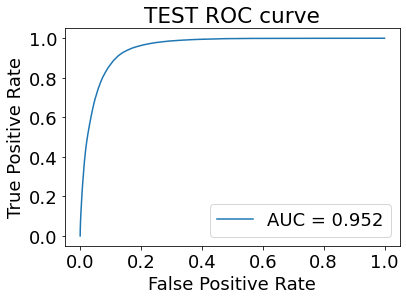

AUC: 0.952
Optimal threshold: 0.248
197615/197615 [==============================] - 51s 257us/sample - loss: 0.2756 - acc: 0.8823
30
TEST
Mouse 1
(197505, 50, 31)


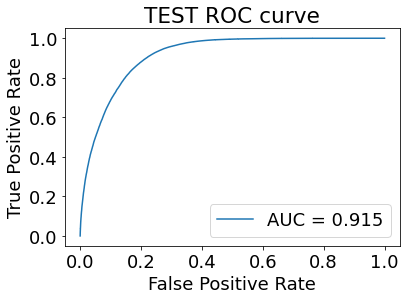

AUC: 0.915
Optimal threshold: 0.148
197505/197505 [==============================] - 51s 257us/sample - loss: 0.3861 - acc: 0.8259
40
TEST
Mouse 1
(197395, 50, 31)


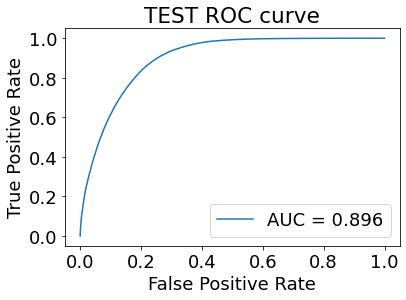

AUC: 0.896
Optimal threshold: 0.116
197395/197395 [==============================] - 52s 263us/sample - loss: 0.4384 - acc: 0.8040
50
TEST
Mouse 1
(197285, 50, 31)


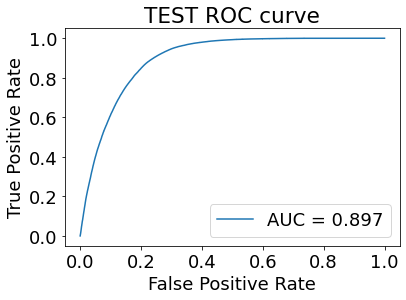

AUC: 0.897
Optimal threshold: 0.326
197285/197285 [==============================] - 51s 260us/sample - loss: 0.4149 - acc: 0.8177
60
TEST
Mouse 1
(197175, 50, 31)


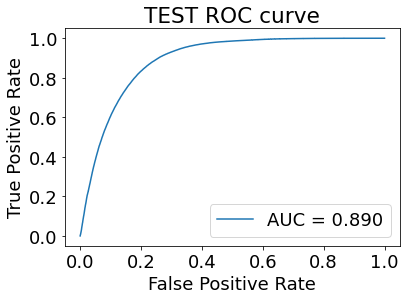

AUC: 0.890
Optimal threshold: 0.376
197175/197175 [==============================] - 51s 260us/sample - loss: 0.4443 - acc: 0.8126
-60
TEST
Mouse 2
(215100, 50, 31)


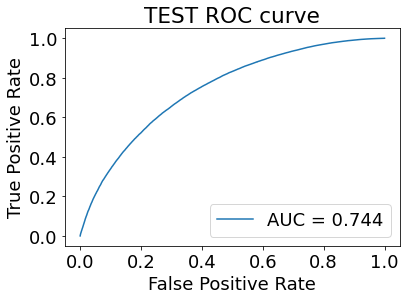

AUC: 0.744
Optimal threshold: 0.520
215100/215100 [==============================] - 57s 263us/sample - loss: 0.5810 - acc: 0.6959
-50
TEST
Mouse 2
(215220, 50, 31)


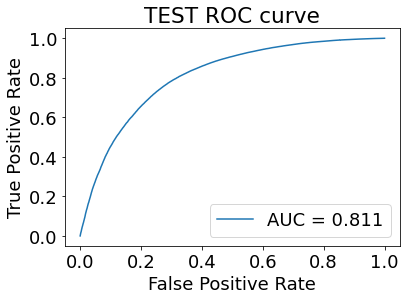

AUC: 0.811
Optimal threshold: 0.451
215220/215220 [==============================] - 57s 263us/sample - loss: 0.5455 - acc: 0.7267
-40
TEST
Mouse 2
(215340, 50, 31)


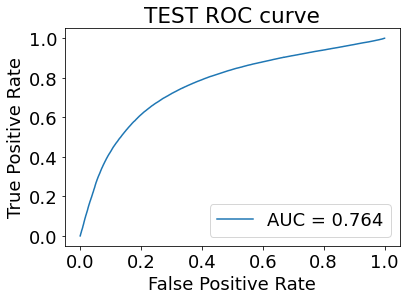

AUC: 0.764
Optimal threshold: 0.286
215340/215340 [==============================] - 56s 260us/sample - loss: 0.7593 - acc: 0.6219
-30
TEST
Mouse 2
(215460, 50, 31)


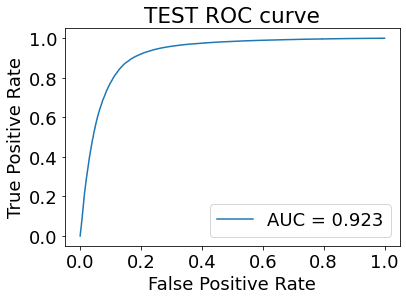

AUC: 0.923
Optimal threshold: 0.521
215460/215460 [==============================] - 52s 243us/sample - loss: 0.3534 - acc: 0.8762
-20
TEST
Mouse 2
(215580, 50, 31)


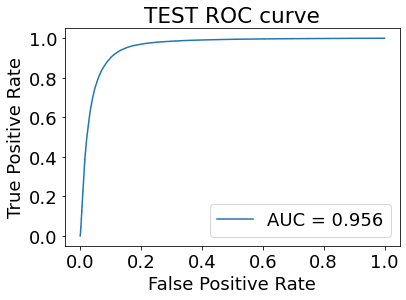

AUC: 0.956
Optimal threshold: 0.475
215580/215580 [==============================] - 56s 258us/sample - loss: 0.2658 - acc: 0.9091
-10
TEST
Mouse 2
(215640, 50, 31)


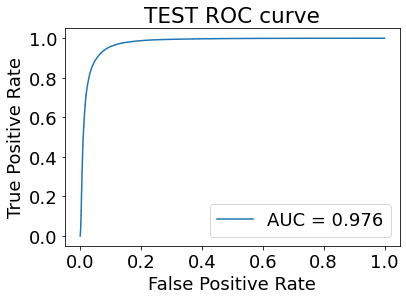

AUC: 0.976
Optimal threshold: 0.476
215640/215640 [==============================] - 55s 257us/sample - loss: 0.1872 - acc: 0.9334
0
TEST
Mouse 2
(215640, 50, 31)


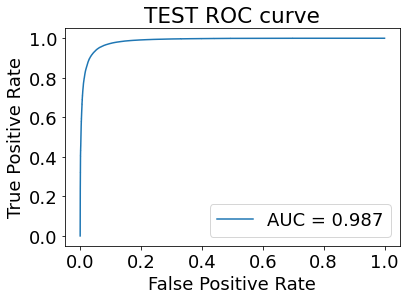

AUC: 0.987
Optimal threshold: 0.551
215640/215640 [==============================] - 57s 263us/sample - loss: 0.1443 - acc: 0.9485
10
TEST
Mouse 2
(215640, 50, 31)


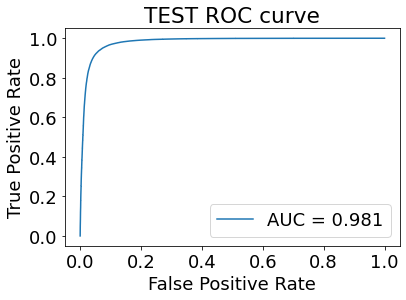

AUC: 0.981
Optimal threshold: 0.600
215640/215640 [==============================] - 57s 262us/sample - loss: 0.1606 - acc: 0.9446
20
TEST
Mouse 2
(215580, 50, 31)


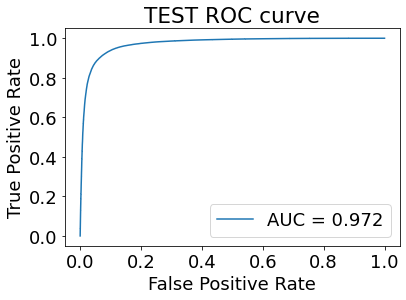

AUC: 0.972
Optimal threshold: 0.703
215580/215580 [==============================] - 57s 262us/sample - loss: 0.2003 - acc: 0.9248
30
TEST
Mouse 2
(215460, 50, 31)


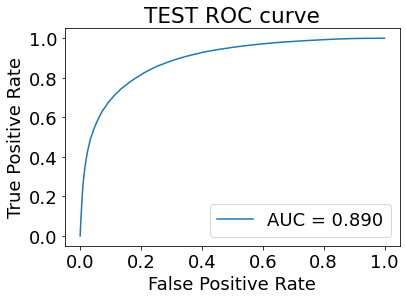

AUC: 0.890
Optimal threshold: 0.693
215460/215460 [==============================] - 56s 262us/sample - loss: 0.4099 - acc: 0.8215
40
TEST
Mouse 2
(215340, 50, 31)


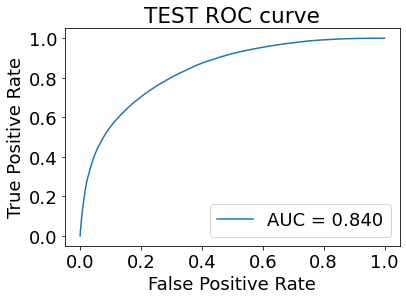

AUC: 0.840
Optimal threshold: 0.302
215340/215340 [==============================] - 57s 262us/sample - loss: 0.6477 - acc: 0.6989
50
TEST
Mouse 2
(215220, 50, 31)


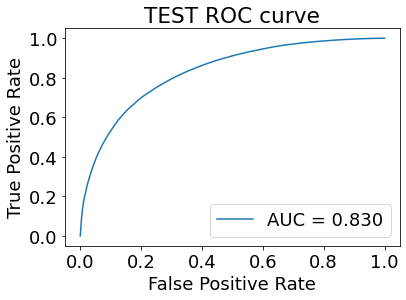

AUC: 0.830
Optimal threshold: 0.358
215220/215220 [==============================] - 58s 270us/sample - loss: 0.6763 - acc: 0.7183
60
TEST
Mouse 2
(215100, 50, 31)


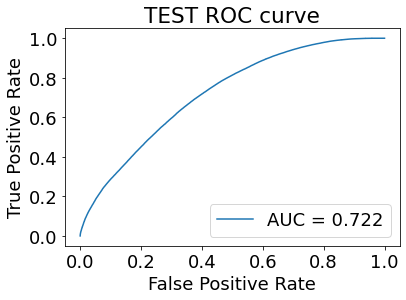

AUC: 0.722
Optimal threshold: 0.331
215100/215100 [==============================] - 58s 269us/sample - loss: 0.7289 - acc: 0.6551
-60
TEST
Mouse 2
(215100, 50, 31)


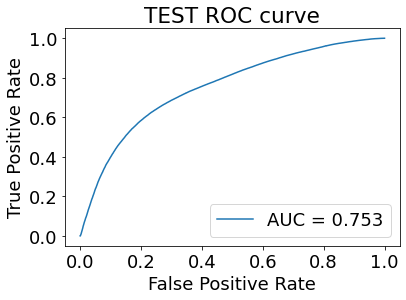

AUC: 0.753
Optimal threshold: 0.605
215100/215100 [==============================] - 60s 279us/sample - loss: 0.6194 - acc: 0.7005
-50
TEST
Mouse 2
(215220, 50, 31)


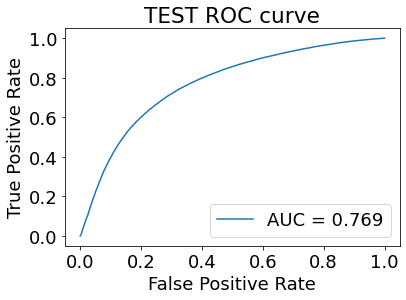

AUC: 0.769
Optimal threshold: 0.514
215220/215220 [==============================] - 59s 275us/sample - loss: 0.5982 - acc: 0.7129
-40
TEST
Mouse 2
(215340, 50, 31)


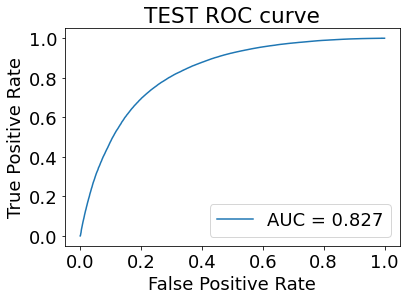

AUC: 0.827
Optimal threshold: 0.466
215340/215340 [==============================] - 60s 279us/sample - loss: 0.5293 - acc: 0.7493
-30
TEST
Mouse 2
(215460, 50, 31)


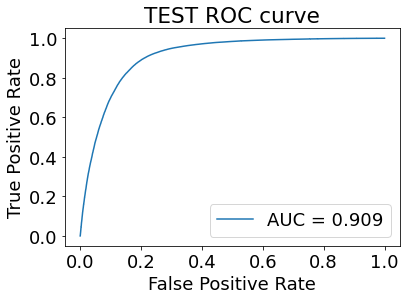

AUC: 0.909
Optimal threshold: 0.397
215460/215460 [==============================] - 60s 280us/sample - loss: 0.4025 - acc: 0.8322
-20
TEST
Mouse 2
(215580, 50, 31)


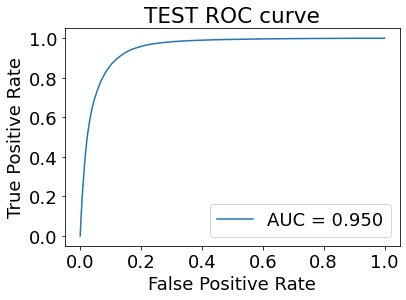

AUC: 0.950
Optimal threshold: 0.292
215580/215580 [==============================] - 59s 274us/sample - loss: 0.3309 - acc: 0.8617
-10
TEST
Mouse 2
(215640, 50, 31)


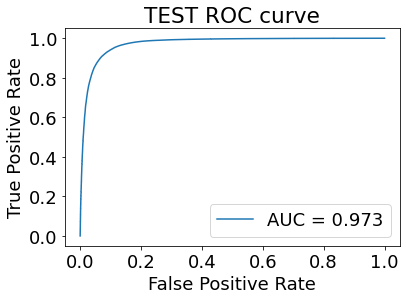

AUC: 0.973
Optimal threshold: 0.316
215640/215640 [==============================] - 62s 287us/sample - loss: 0.2471 - acc: 0.9073
0
TEST
Mouse 2
(215640, 50, 31)


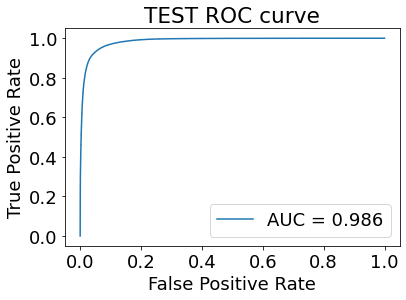

AUC: 0.986
Optimal threshold: 0.439
215640/215640 [==============================] - 67s 313us/sample - loss: 0.1625 - acc: 0.9404
10
TEST
Mouse 2
(215640, 50, 31)


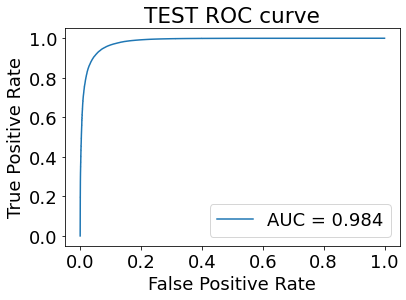

AUC: 0.984
Optimal threshold: 0.379
215640/215640 [==============================] - 63s 291us/sample - loss: 0.1746 - acc: 0.9332
20
TEST
Mouse 2
(215580, 50, 31)


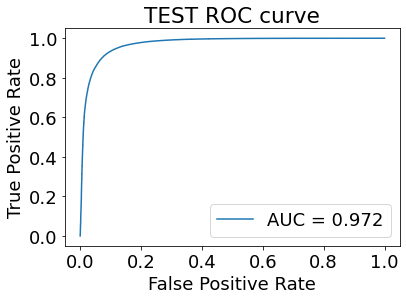

AUC: 0.972
Optimal threshold: 0.563
215580/215580 [==============================] - 64s 295us/sample - loss: 0.1995 - acc: 0.9240
30
TEST
Mouse 2
(215460, 50, 31)


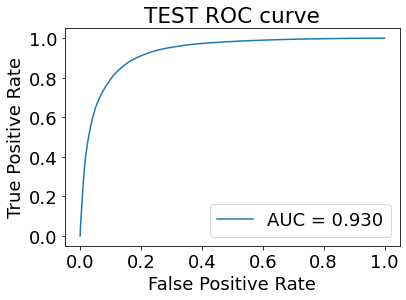

AUC: 0.930
Optimal threshold: 0.366
215460/215460 [==============================] - 69s 318us/sample - loss: 0.3916 - acc: 0.8468
40
TEST
Mouse 2
(215340, 50, 31)


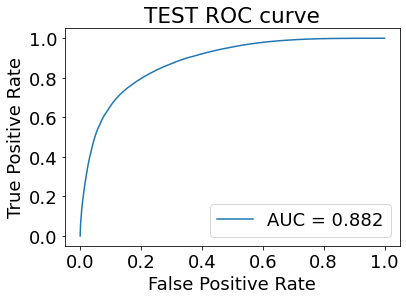

AUC: 0.882
Optimal threshold: 0.439
215340/215340 [==============================] - 69s 319us/sample - loss: 0.5136 - acc: 0.7851
50
TEST
Mouse 2
(215220, 50, 31)


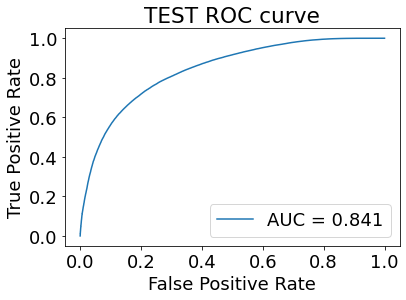

AUC: 0.841
Optimal threshold: 0.470
215220/215220 [==============================] - 69s 319us/sample - loss: 0.5652 - acc: 0.7534
60
TEST
Mouse 2
(215100, 50, 31)


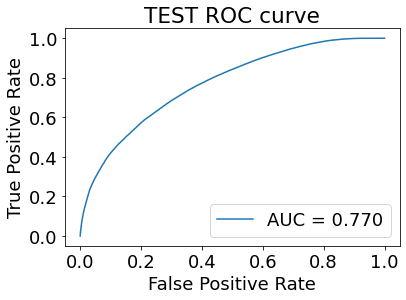

AUC: 0.770
Optimal threshold: 0.430
215100/215100 [==============================] - 69s 320us/sample - loss: 0.7004 - acc: 0.6742
-60
TEST
Mouse 2
(215100, 50, 31)


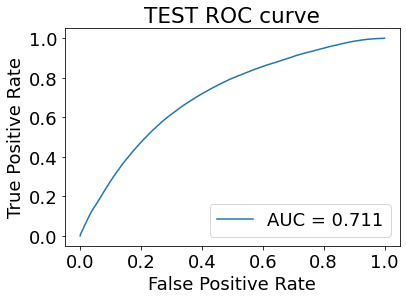

AUC: 0.711
Optimal threshold: 0.595
215100/215100 [==============================] - 68s 317us/sample - loss: 0.6139 - acc: 0.6914
-50
TEST
Mouse 2
(215220, 50, 31)


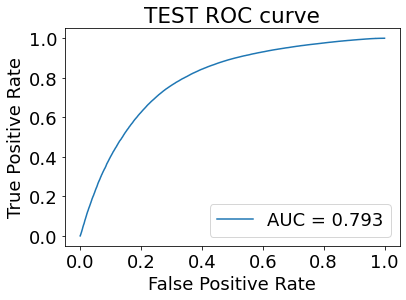

AUC: 0.793
Optimal threshold: 0.581
215220/215220 [==============================] - 68s 314us/sample - loss: 0.5190 - acc: 0.7592
-40
TEST
Mouse 2
(215340, 50, 31)


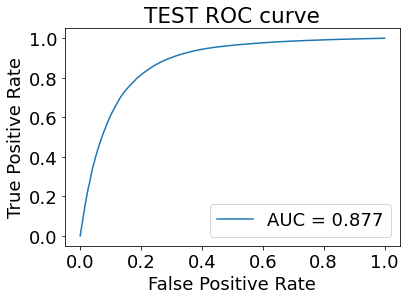

AUC: 0.877
Optimal threshold: 0.593
215340/215340 [==============================] - 63s 291us/sample - loss: 0.4097 - acc: 0.8332
-30
TEST
Mouse 2
(215460, 50, 31)


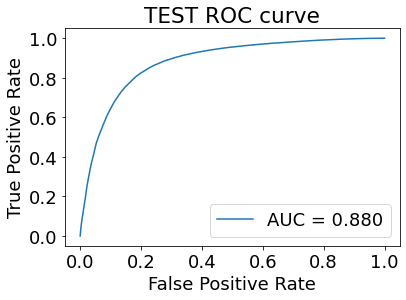

AUC: 0.880
Optimal threshold: 0.431
215460/215460 [==============================] - 61s 281us/sample - loss: 0.4630 - acc: 0.8002
-20
TEST
Mouse 2
(215580, 50, 31)


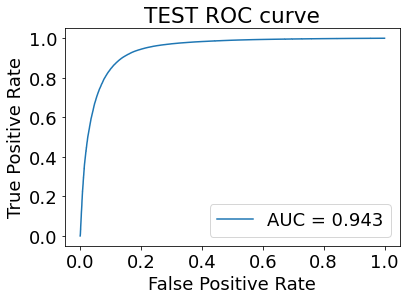

AUC: 0.943
Optimal threshold: 0.326
215580/215580 [==============================] - 61s 283us/sample - loss: 0.3489 - acc: 0.8559
-10
TEST
Mouse 2
(215640, 50, 31)


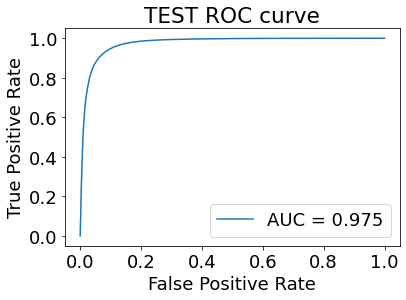

AUC: 0.975
Optimal threshold: 0.406
215640/215640 [==============================] - 61s 282us/sample - loss: 0.2080 - acc: 0.9233
0
TEST
Mouse 2
(215640, 50, 31)


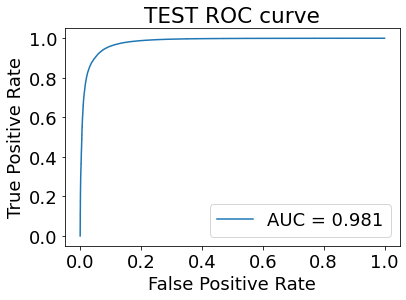

AUC: 0.981
Optimal threshold: 0.363
215640/215640 [==============================] - 60s 281us/sample - loss: 0.1944 - acc: 0.9239
10
TEST
Mouse 2
(215640, 50, 31)


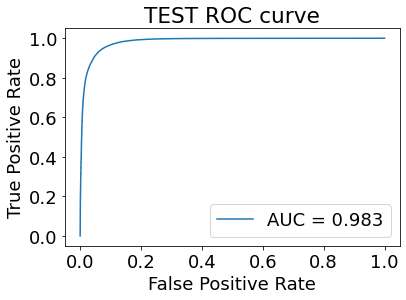

AUC: 0.983
Optimal threshold: 0.513
215640/215640 [==============================] - 62s 288us/sample - loss: 0.1589 - acc: 0.9399
20
TEST
Mouse 2
(215580, 50, 31)


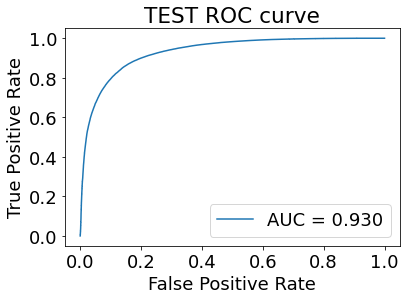

AUC: 0.930
Optimal threshold: 0.376
215580/215580 [==============================] - 61s 283us/sample - loss: 0.3833 - acc: 0.8371
30
TEST
Mouse 2
(215460, 50, 31)


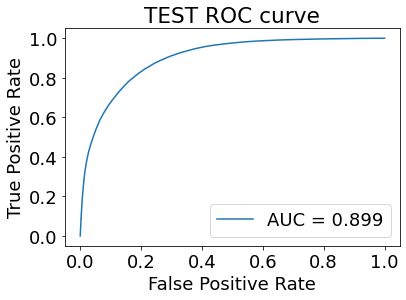

AUC: 0.899
Optimal threshold: 0.185
215460/215460 [==============================] - 61s 284us/sample - loss: 0.5853 - acc: 0.7629
40
TEST
Mouse 2
(215340, 50, 31)


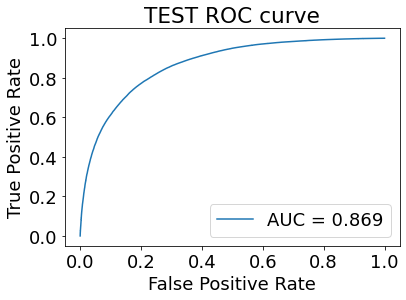

AUC: 0.869
Optimal threshold: 0.316
215340/215340 [==============================] - 61s 284us/sample - loss: 0.6102 - acc: 0.7464
50
TEST
Mouse 2
(215220, 50, 31)


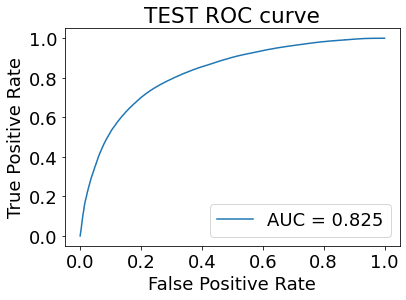

AUC: 0.825
Optimal threshold: 0.324
215220/215220 [==============================] - 61s 284us/sample - loss: 0.7497 - acc: 0.7078
60
TEST
Mouse 2
(215100, 50, 31)


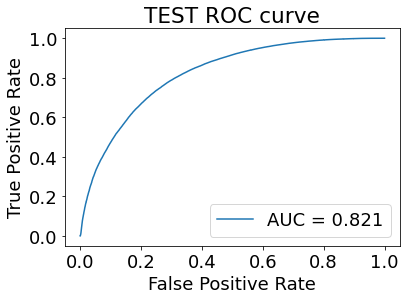

AUC: 0.821
Optimal threshold: 0.376
215100/215100 [==============================] - 56s 262us/sample - loss: 0.6471 - acc: 0.7355
-60
TEST
Mouse 2
(215100, 50, 31)


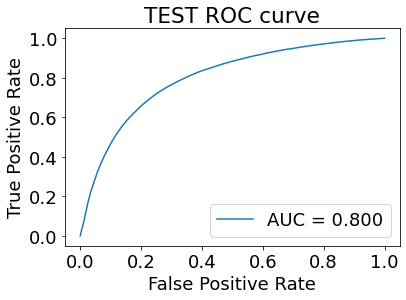

AUC: 0.800
Optimal threshold: 0.447
215100/215100 [==============================] - 62s 287us/sample - loss: 0.5806 - acc: 0.7131
-50
TEST
Mouse 2
(215220, 50, 31)


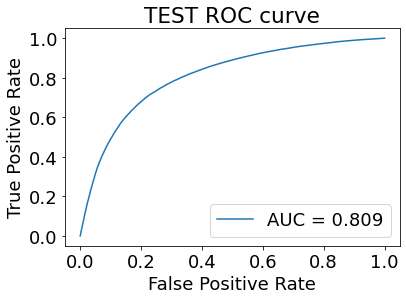

AUC: 0.809
Optimal threshold: 0.523
215220/215220 [==============================] - 62s 286us/sample - loss: 0.5444 - acc: 0.7392
-40
TEST
Mouse 2
(215340, 50, 31)


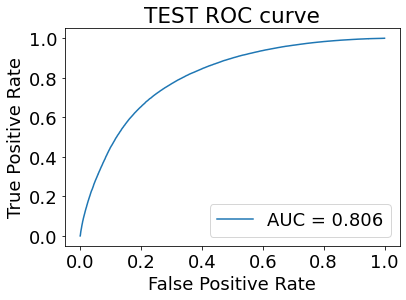

AUC: 0.806
Optimal threshold: 0.394
215340/215340 [==============================] - 62s 287us/sample - loss: 0.5915 - acc: 0.7017
-30
TEST
Mouse 2
(215460, 50, 31)


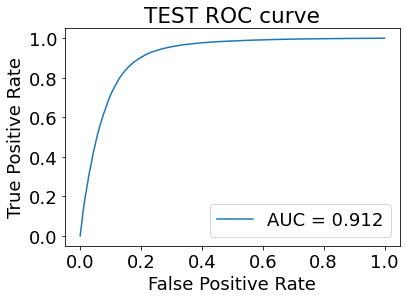

AUC: 0.912
Optimal threshold: 0.340
215460/215460 [==============================] - 62s 287us/sample - loss: 0.4131 - acc: 0.8222
-20
TEST
Mouse 2
(215580, 50, 31)


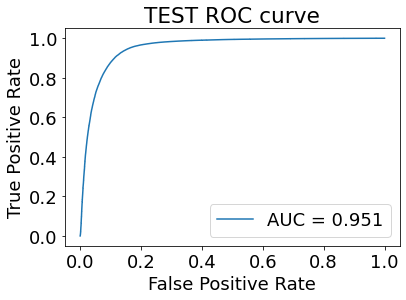

AUC: 0.951
Optimal threshold: 0.225
215580/215580 [==============================] - 60s 280us/sample - loss: 0.3675 - acc: 0.8415
-10
TEST
Mouse 2
(215640, 50, 31)


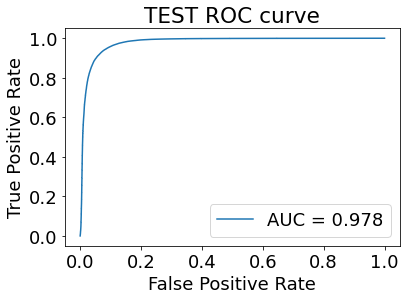

AUC: 0.978
Optimal threshold: 0.377
215640/215640 [==============================] - 62s 288us/sample - loss: 0.2073 - acc: 0.9238
0
TEST
Mouse 2
(215640, 50, 31)


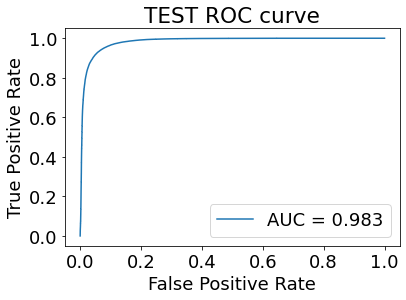

AUC: 0.983
Optimal threshold: 0.435
215640/215640 [==============================] - 62s 288us/sample - loss: 0.1713 - acc: 0.9353
10
TEST
Mouse 2
(215640, 50, 31)


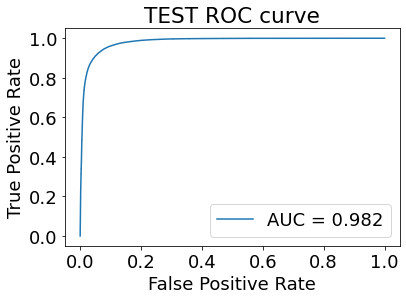

AUC: 0.982
Optimal threshold: 0.459
215640/215640 [==============================] - 62s 287us/sample - loss: 0.1743 - acc: 0.9343
20
TEST
Mouse 2
(215580, 50, 31)


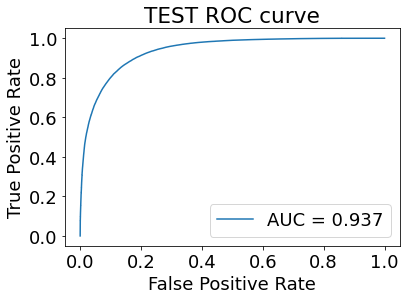

AUC: 0.937
Optimal threshold: 0.249
215580/215580 [==============================] - 62s 289us/sample - loss: 0.4390 - acc: 0.8206
30
TEST
Mouse 2
(215460, 50, 31)


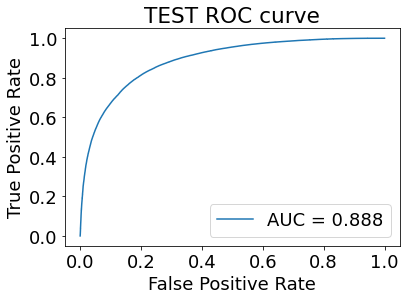

AUC: 0.888
Optimal threshold: 0.201
215460/215460 [==============================] - 60s 279us/sample - loss: 0.6423 - acc: 0.7405
40
TEST
Mouse 2
(215340, 50, 31)


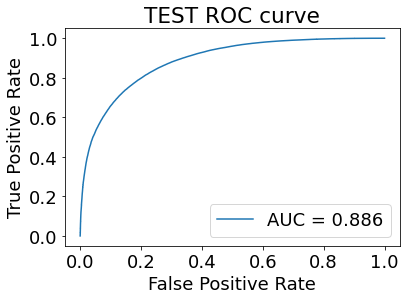

AUC: 0.886
Optimal threshold: 0.426
215340/215340 [==============================] - 61s 283us/sample - loss: 0.4696 - acc: 0.7931
50
TEST
Mouse 2
(215220, 50, 31)


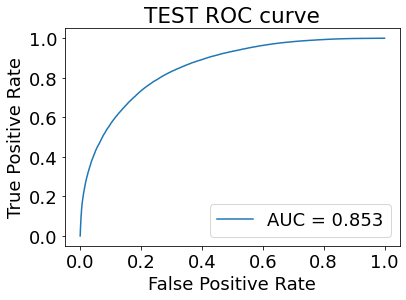

AUC: 0.853
Optimal threshold: 0.401
215220/215220 [==============================] - 61s 284us/sample - loss: 0.5593 - acc: 0.7542
60
TEST
Mouse 2
(215100, 50, 31)


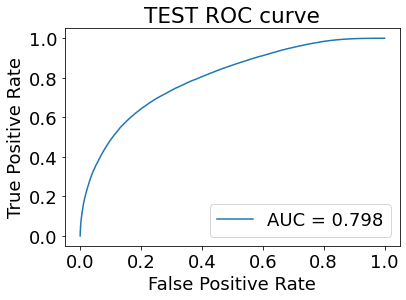

AUC: 0.798
Optimal threshold: 0.362
215100/215100 [==============================] - 61s 284us/sample - loss: 0.8083 - acc: 0.6863
-60
TEST
Mouse 3
(250950, 50, 31)


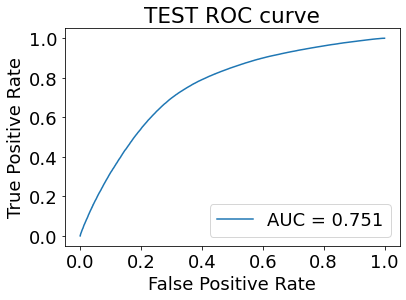

AUC: 0.751
Optimal threshold: 0.670
250950/250950 [==============================] - 72s 287us/sample - loss: 0.5622 - acc: 0.7273
-50
TEST
Mouse 3
(251090, 50, 31)


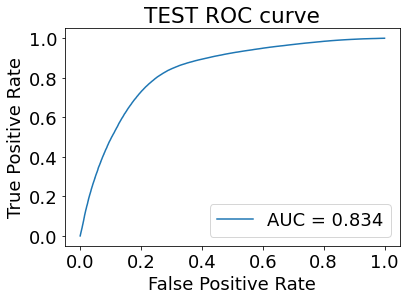

AUC: 0.834
Optimal threshold: 0.698
251090/251090 [==============================] - 72s 285us/sample - loss: 0.4781 - acc: 0.7910
-40
TEST
Mouse 3
(251230, 50, 31)


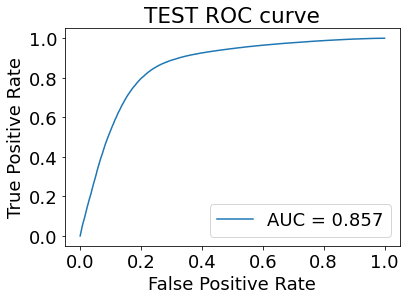

AUC: 0.857
Optimal threshold: 0.776
251230/251230 [==============================] - 72s 287us/sample - loss: 0.4674 - acc: 0.8117
-30
TEST
Mouse 3
(251370, 50, 31)


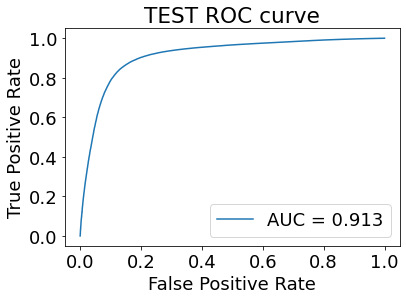

AUC: 0.913
Optimal threshold: 0.669
251370/251370 [==============================] - 73s 289us/sample - loss: 0.3506 - acc: 0.8652
-20
TEST
Mouse 3
(251510, 50, 31)


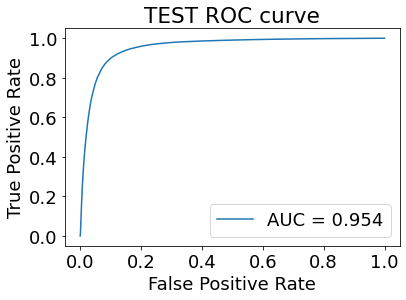

AUC: 0.954
Optimal threshold: 0.707
251510/251510 [==============================] - 73s 290us/sample - loss: 0.2520 - acc: 0.9071
-10
TEST
Mouse 3
(251580, 50, 31)


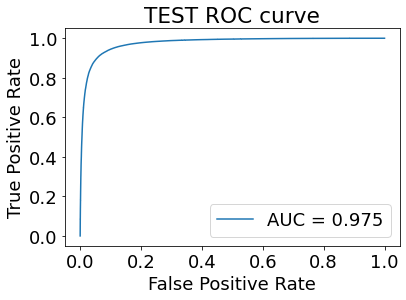

AUC: 0.975
Optimal threshold: 0.735
251580/251580 [==============================] - 73s 290us/sample - loss: 0.1898 - acc: 0.9281
0
TEST
Mouse 3
(251580, 50, 31)


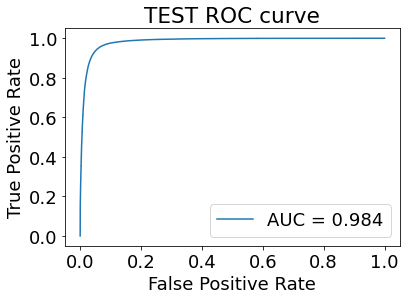

AUC: 0.984
Optimal threshold: 0.661
251580/251580 [==============================] - 73s 290us/sample - loss: 0.1499 - acc: 0.9492
10
TEST
Mouse 3
(251580, 50, 31)


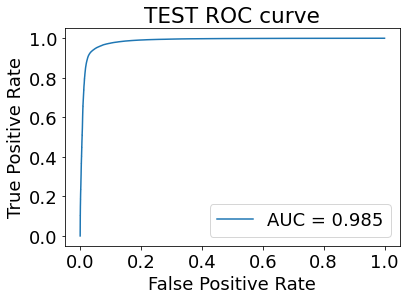

AUC: 0.985
Optimal threshold: 0.786
251580/251580 [==============================] - 74s 296us/sample - loss: 0.1485 - acc: 0.9474
20
TEST
Mouse 3
(251510, 50, 31)


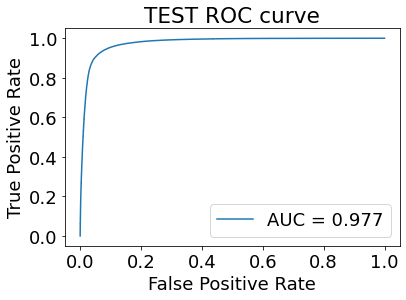

AUC: 0.977
Optimal threshold: 0.779
251510/251510 [==============================] - 74s 296us/sample - loss: 0.1894 - acc: 0.9277
30
TEST
Mouse 3
(251370, 50, 31)


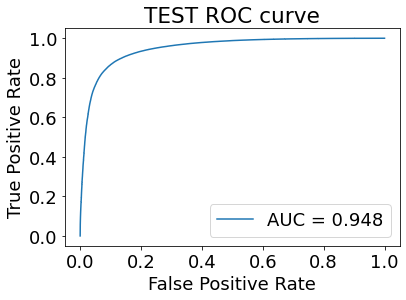

AUC: 0.948
Optimal threshold: 0.765
251370/251370 [==============================] - 74s 296us/sample - loss: 0.2837 - acc: 0.8810
40
TEST
Mouse 3
(251230, 50, 31)


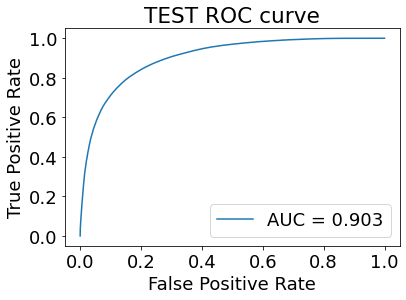

AUC: 0.903
Optimal threshold: 0.758
251230/251230 [==============================] - 75s 297us/sample - loss: 0.3995 - acc: 0.8341
50
TEST
Mouse 3
(251090, 50, 31)


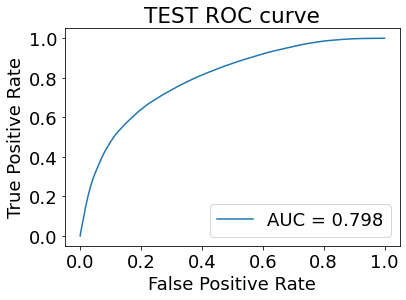

AUC: 0.798
Optimal threshold: 0.766
251090/251090 [==============================] - 75s 297us/sample - loss: 0.7092 - acc: 0.7319
60
TEST
Mouse 3
(250950, 50, 31)


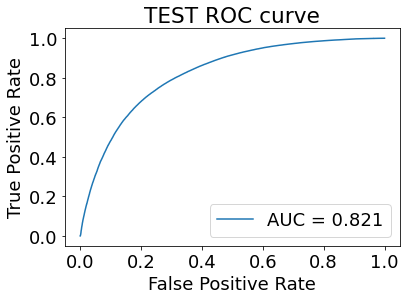

AUC: 0.821
Optimal threshold: 0.786
250950/250950 [==============================] - 72s 287us/sample - loss: 0.5764 - acc: 0.7707
-60
TEST
Mouse 3
(250950, 50, 31)


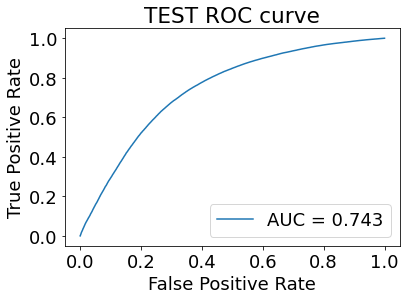

AUC: 0.743
Optimal threshold: 0.668
250950/250950 [==============================] - 74s 296us/sample - loss: 0.5686 - acc: 0.7245
-50
TEST
Mouse 3
(251090, 50, 31)


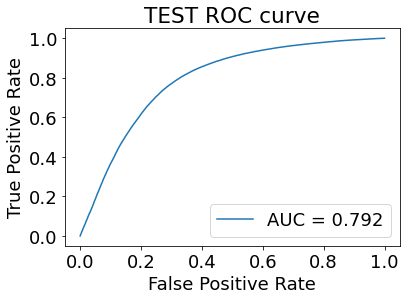

AUC: 0.792
Optimal threshold: 0.738
251090/251090 [==============================] - 74s 296us/sample - loss: 0.5399 - acc: 0.7592
-40
TEST
Mouse 3
(251230, 50, 31)


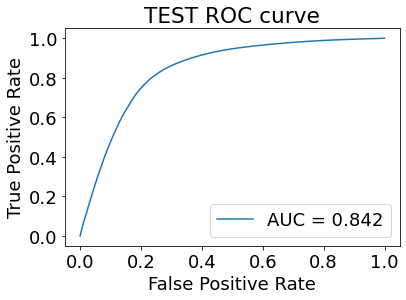

AUC: 0.842
Optimal threshold: 0.625
251230/251230 [==============================] - 75s 298us/sample - loss: 0.4573 - acc: 0.8062
-30
TEST
Mouse 3
(251370, 50, 31)


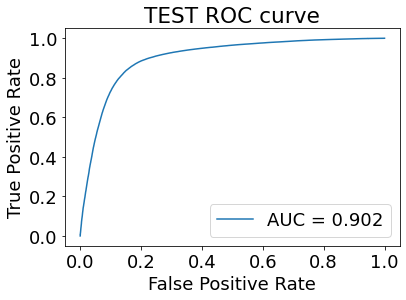

AUC: 0.902
Optimal threshold: 0.675
251370/251370 [==============================] - 75s 299us/sample - loss: 0.3737 - acc: 0.8540
-20
TEST
Mouse 3
(251510, 50, 31)


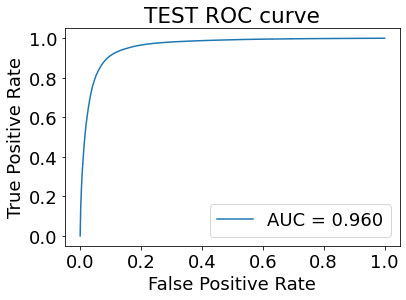

AUC: 0.960
Optimal threshold: 0.791
251510/251510 [==============================] - 76s 300us/sample - loss: 0.2442 - acc: 0.9100
-10
TEST
Mouse 3
(251580, 50, 31)


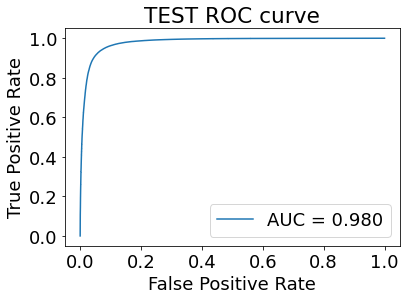

AUC: 0.980
Optimal threshold: 0.831
251580/251580 [==============================] - 75s 297us/sample - loss: 0.1758 - acc: 0.9351
0
TEST
Mouse 3
(251580, 50, 31)


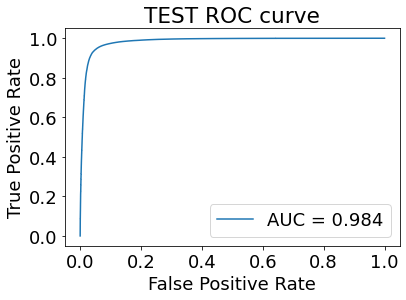

AUC: 0.984
Optimal threshold: 0.774
251580/251580 [==============================] - 75s 298us/sample - loss: 0.1478 - acc: 0.9471
10
TEST
Mouse 3
(251580, 50, 31)


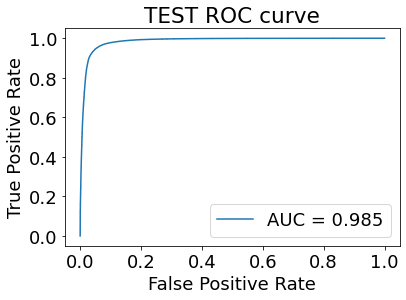

AUC: 0.985
Optimal threshold: 0.738
251580/251580 [==============================] - 75s 300us/sample - loss: 0.1407 - acc: 0.9511
20
TEST
Mouse 3
(251510, 50, 31)


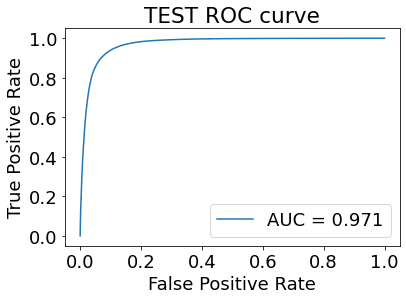

AUC: 0.971
Optimal threshold: 0.757
251510/251510 [==============================] - 76s 304us/sample - loss: 0.2056 - acc: 0.9273
30
TEST
Mouse 3
(251370, 50, 31)


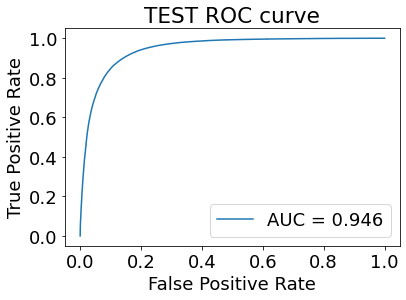

AUC: 0.946
Optimal threshold: 0.748
251370/251370 [==============================] - 76s 302us/sample - loss: 0.2852 - acc: 0.8901
40
TEST
Mouse 3
(251230, 50, 31)


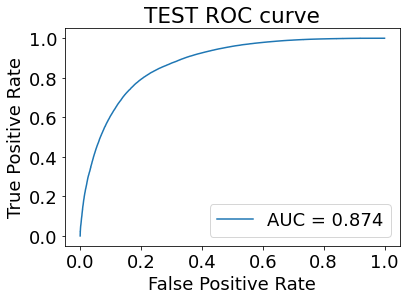

AUC: 0.874
Optimal threshold: 0.791
251230/251230 [==============================] - 76s 303us/sample - loss: 0.4403 - acc: 0.8130
50
TEST
Mouse 3
(251090, 50, 31)


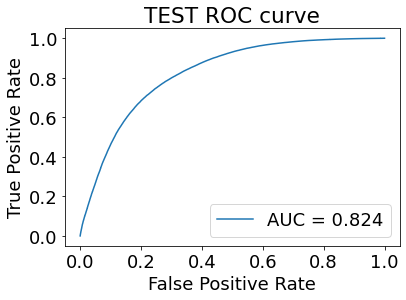

AUC: 0.824
Optimal threshold: 0.730
251090/251090 [==============================] - 76s 304us/sample - loss: 0.5805 - acc: 0.7760
60
TEST
Mouse 3
(250950, 50, 31)


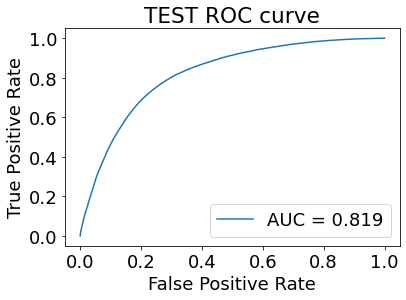

AUC: 0.819
Optimal threshold: 0.881
250950/250950 [==============================] - 77s 308us/sample - loss: 0.6241 - acc: 0.7696
-60
TEST
Mouse 3
(250950, 50, 31)


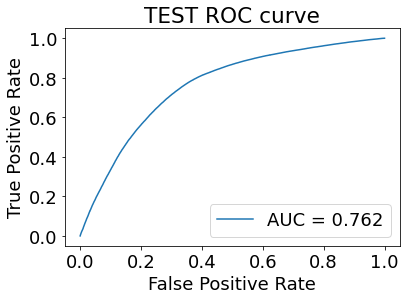

AUC: 0.762
Optimal threshold: 0.689
250950/250950 [==============================] - 77s 308us/sample - loss: 0.5529 - acc: 0.7329
-50
TEST
Mouse 3
(251090, 50, 31)


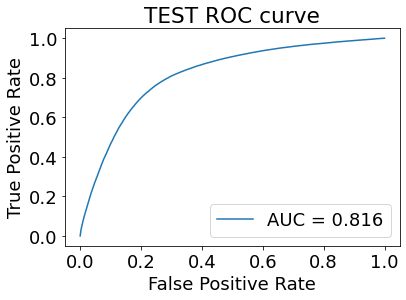

AUC: 0.816
Optimal threshold: 0.689
251090/251090 [==============================] - 78s 310us/sample - loss: 0.5020 - acc: 0.7718
-40
TEST
Mouse 3
(251230, 50, 31)


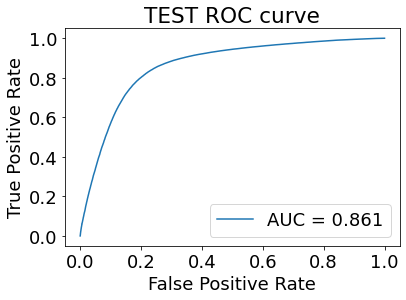

AUC: 0.861
Optimal threshold: 0.738
251230/251230 [==============================] - 78s 310us/sample - loss: 0.4471 - acc: 0.8071
-30
TEST
Mouse 3
(251370, 50, 31)


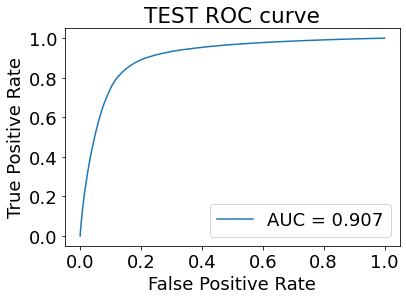

AUC: 0.907
Optimal threshold: 0.733
251370/251370 [==============================] - 77s 308us/sample - loss: 0.3686 - acc: 0.8538
-20
TEST
Mouse 3
(251510, 50, 31)


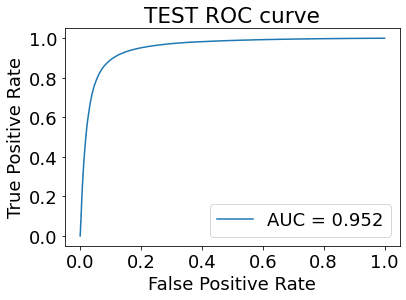

AUC: 0.952
Optimal threshold: 0.798
251510/251510 [==============================] - 79s 312us/sample - loss: 0.2687 - acc: 0.8969
-10
TEST
Mouse 3
(251580, 50, 31)


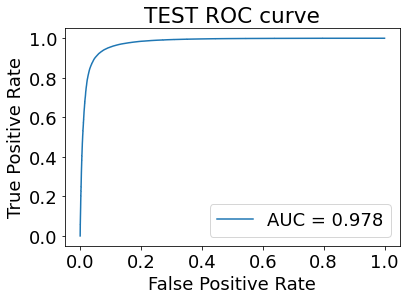

AUC: 0.978
Optimal threshold: 0.735
251580/251580 [==============================] - 78s 312us/sample - loss: 0.1758 - acc: 0.9346
0
TEST
Mouse 3
(251580, 50, 31)


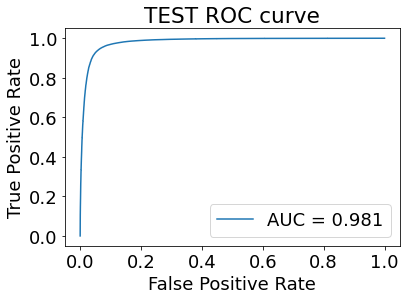

AUC: 0.981
Optimal threshold: 0.720
251580/251580 [==============================] - 78s 311us/sample - loss: 0.1580 - acc: 0.9448
10
TEST
Mouse 3
(251580, 50, 31)


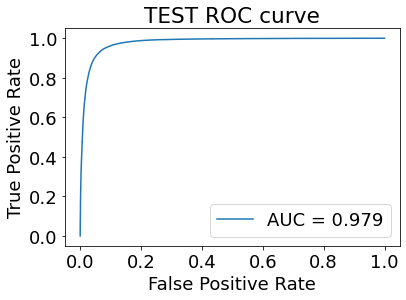

AUC: 0.979
Optimal threshold: 0.498
251580/251580 [==============================] - 78s 312us/sample - loss: 0.1778 - acc: 0.9374
20
TEST
Mouse 3
(251510, 50, 31)


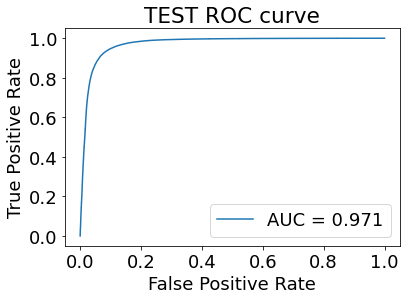

AUC: 0.971
Optimal threshold: 0.678
251510/251510 [==============================] - 79s 313us/sample - loss: 0.1894 - acc: 0.9320
30
TEST
Mouse 3
(251370, 50, 31)


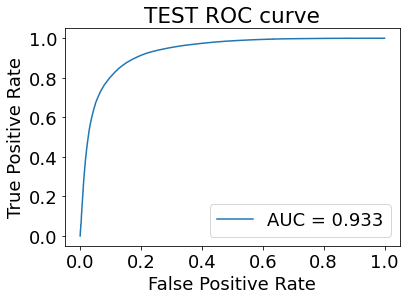

AUC: 0.933
Optimal threshold: 0.610
251370/251370 [==============================] - 80s 318us/sample - loss: 0.3210 - acc: 0.8727
40
TEST
Mouse 3
(251230, 50, 31)


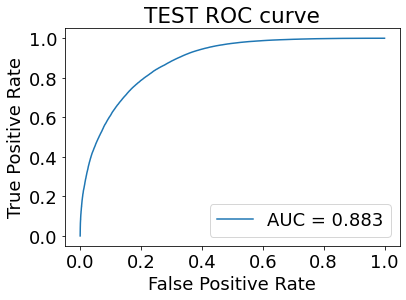

AUC: 0.883
Optimal threshold: 0.510
251230/251230 [==============================] - 80s 317us/sample - loss: 0.4351 - acc: 0.8089
50
TEST
Mouse 3
(251090, 50, 31)


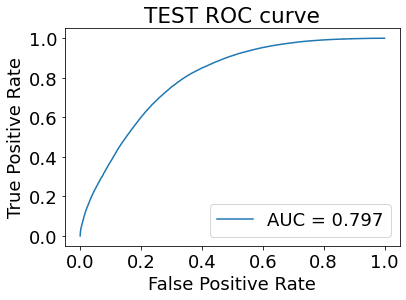

AUC: 0.797
Optimal threshold: 0.642
251090/251090 [==============================] - 80s 317us/sample - loss: 0.6192 - acc: 0.7614
60
TEST
Mouse 3
(250950, 50, 31)


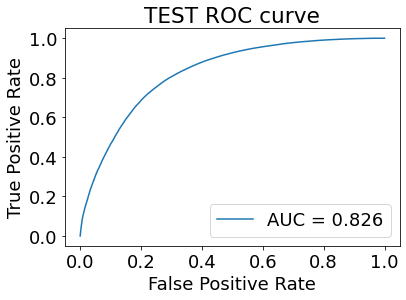

AUC: 0.826
Optimal threshold: 0.690
250950/250950 [==============================] - 80s 319us/sample - loss: 0.5623 - acc: 0.7784
-60
TEST
Mouse 3
(250950, 50, 31)


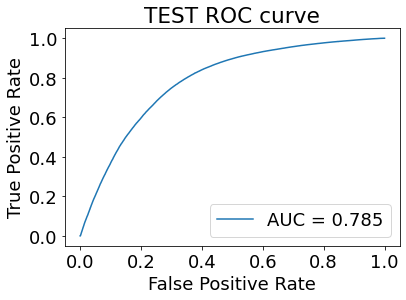

AUC: 0.785
Optimal threshold: 0.726
250950/250950 [==============================] - 80s 320us/sample - loss: 0.5348 - acc: 0.7449
-50
TEST
Mouse 3
(251090, 50, 31)


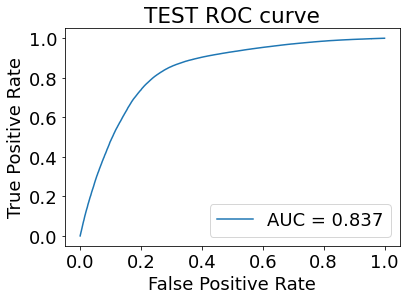

AUC: 0.837
Optimal threshold: 0.768
251090/251090 [==============================] - 81s 321us/sample - loss: 0.4833 - acc: 0.7860
-40
TEST
Mouse 3
(251230, 50, 31)


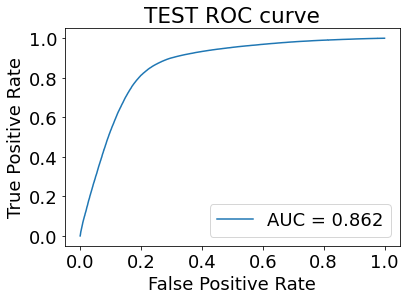

AUC: 0.862
Optimal threshold: 0.682
251230/251230 [==============================] - 80s 320us/sample - loss: 0.4338 - acc: 0.8187
-30
TEST
Mouse 3
(251370, 50, 31)


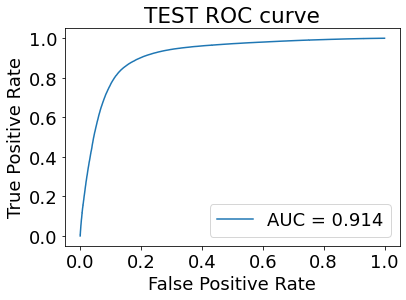

AUC: 0.914
Optimal threshold: 0.751
251370/251370 [==============================] - 80s 319us/sample - loss: 0.3514 - acc: 0.8629
-20
TEST
Mouse 3
(251510, 50, 31)


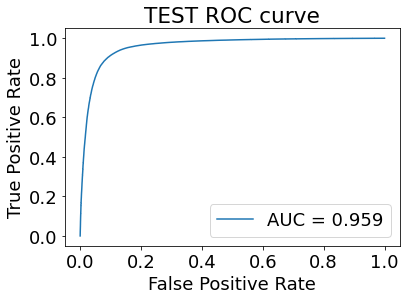

AUC: 0.959
Optimal threshold: 0.719
251510/251510 [==============================] - 81s 321us/sample - loss: 0.2406 - acc: 0.9135
-10
TEST
Mouse 3
(251580, 50, 31)


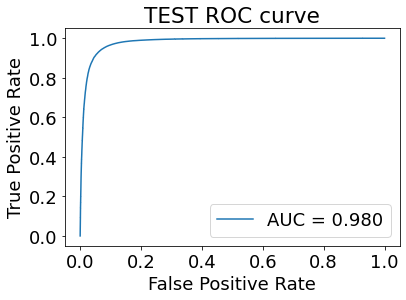

AUC: 0.980
Optimal threshold: 0.711
251580/251580 [==============================] - 81s 323us/sample - loss: 0.1617 - acc: 0.9424
0
TEST
Mouse 3
(251580, 50, 31)


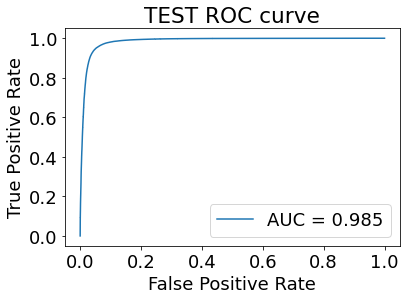

AUC: 0.985
Optimal threshold: 0.783
251580/251580 [==============================] - 81s 322us/sample - loss: 0.1385 - acc: 0.9529
10
TEST
Mouse 3
(251580, 50, 31)


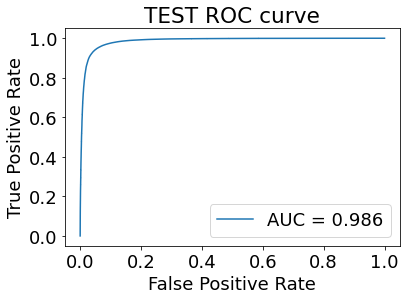

AUC: 0.986
Optimal threshold: 0.760
251580/251580 [==============================] - 81s 323us/sample - loss: 0.1410 - acc: 0.9489
20
TEST
Mouse 3
(251510, 50, 31)


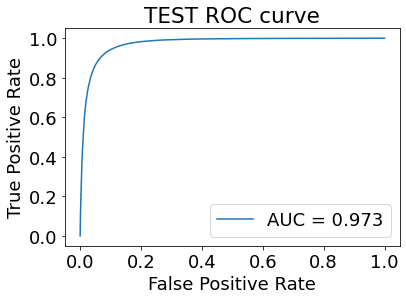

AUC: 0.973
Optimal threshold: 0.378
251510/251510 [==============================] - 82s 328us/sample - loss: 0.2311 - acc: 0.9143
30
TEST
Mouse 3
(251370, 50, 31)


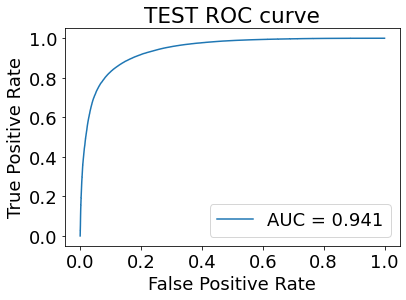

AUC: 0.941
Optimal threshold: 0.317
251370/251370 [==============================] - 83s 329us/sample - loss: 0.3988 - acc: 0.8472
40
TEST
Mouse 3
(251230, 50, 31)


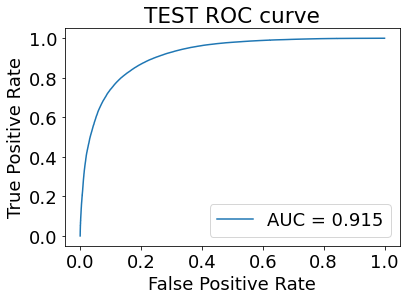

AUC: 0.915
Optimal threshold: 0.248
251230/251230 [==============================] - 82s 328us/sample - loss: 0.5128 - acc: 0.8024
50
TEST
Mouse 3
(251090, 50, 31)


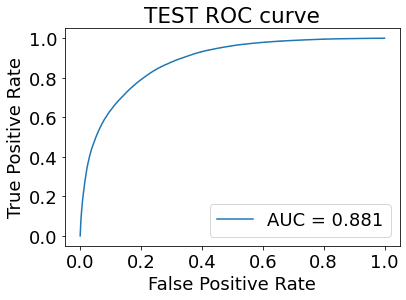

AUC: 0.881
Optimal threshold: 0.030
251090/251090 [==============================] - 82s 327us/sample - loss: 1.0313 - acc: 0.6790
60
TEST
Mouse 3
(250950, 50, 31)


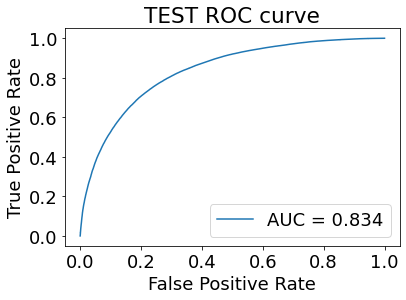

AUC: 0.834
Optimal threshold: 0.245
250950/250950 [==============================] - 82s 327us/sample - loss: 0.7267 - acc: 0.6982
-60
TEST
Mouse 4
(268875, 50, 31)


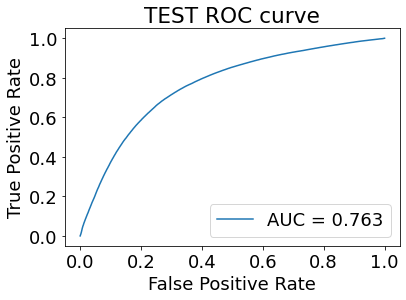

AUC: 0.763
Optimal threshold: 0.548
268875/268875 [==============================] - 88s 329us/sample - loss: 0.6047 - acc: 0.7125
-50
TEST
Mouse 4
(269025, 50, 31)


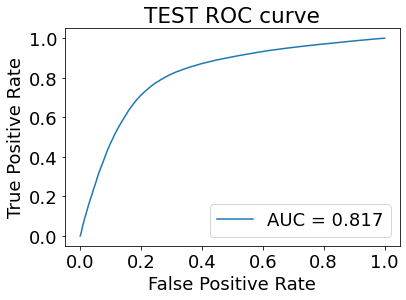

AUC: 0.817
Optimal threshold: 0.534
269025/269025 [==============================] - 85s 315us/sample - loss: 0.5488 - acc: 0.7670
-40
TEST
Mouse 4
(269175, 50, 31)


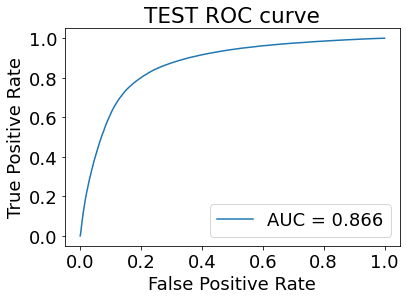

AUC: 0.866
Optimal threshold: 0.681
269175/269175 [==============================] - 88s 328us/sample - loss: 0.4906 - acc: 0.8045
-30
TEST
Mouse 4
(269325, 50, 31)


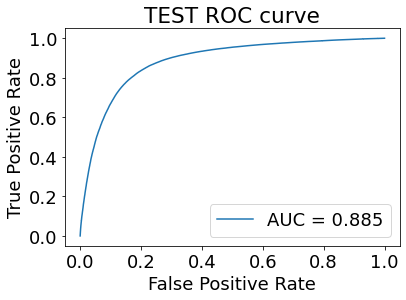

AUC: 0.885
Optimal threshold: 0.517
269325/269325 [==============================] - 89s 329us/sample - loss: 0.4462 - acc: 0.8209
-20
TEST
Mouse 4
(269475, 50, 31)


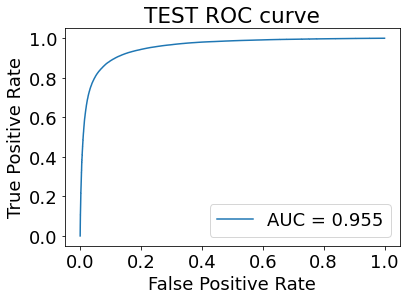

AUC: 0.955
Optimal threshold: 0.719
269475/269475 [==============================] - 89s 330us/sample - loss: 0.2809 - acc: 0.8920
-10
TEST
Mouse 4
(269550, 50, 31)


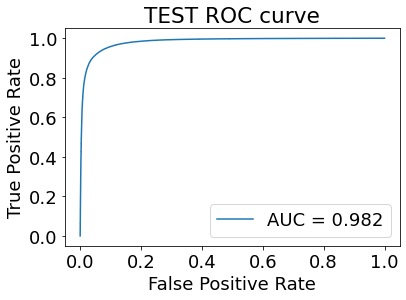

AUC: 0.982
Optimal threshold: 0.782
269550/269550 [==============================] - 90s 333us/sample - loss: 0.1818 - acc: 0.9308
0
TEST
Mouse 4
(269550, 50, 31)


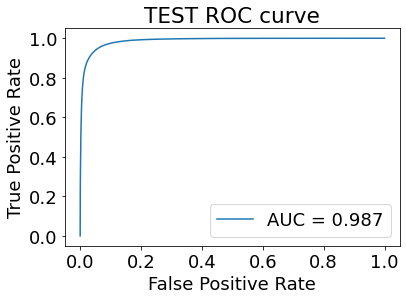

AUC: 0.987
Optimal threshold: 0.742
269550/269550 [==============================] - 90s 333us/sample - loss: 0.1507 - acc: 0.9456
10
TEST
Mouse 4
(269550, 50, 31)


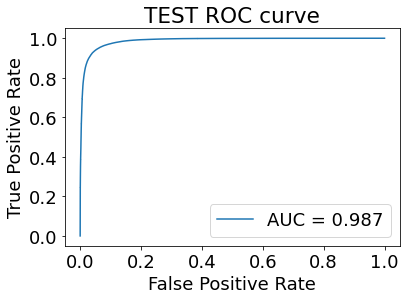

AUC: 0.987
Optimal threshold: 0.739
269550/269550 [==============================] - 86s 321us/sample - loss: 0.1478 - acc: 0.9437
20
TEST
Mouse 4
(269475, 50, 31)


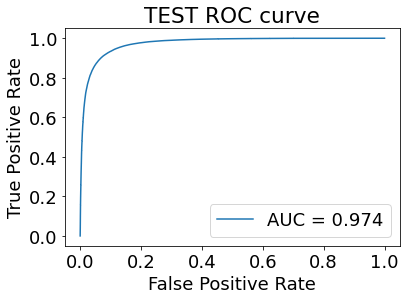

AUC: 0.974
Optimal threshold: 0.502
269475/269475 [==============================] - 90s 334us/sample - loss: 0.2074 - acc: 0.9188
30
TEST
Mouse 4
(269325, 50, 31)


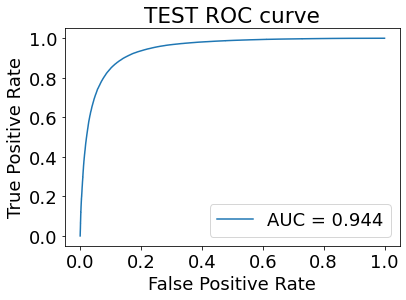

AUC: 0.944
Optimal threshold: 0.466
269325/269325 [==============================] - 90s 335us/sample - loss: 0.3036 - acc: 0.8799
40
TEST
Mouse 4
(269175, 50, 31)


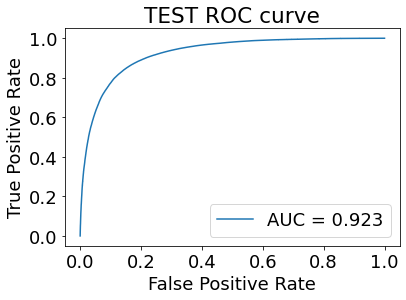

AUC: 0.923
Optimal threshold: 0.595
269175/269175 [==============================] - 90s 335us/sample - loss: 0.3672 - acc: 0.8524
50
TEST
Mouse 4
(269025, 50, 31)


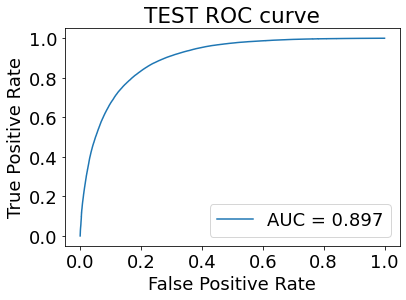

AUC: 0.897
Optimal threshold: 0.263
269025/269025 [==============================] - 90s 335us/sample - loss: 0.4980 - acc: 0.7944
60
TEST
Mouse 4
(268875, 50, 31)


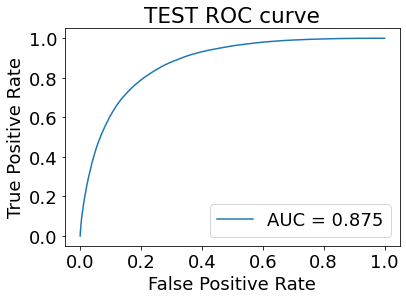

AUC: 0.875
Optimal threshold: 0.231
268875/268875 [==============================] - 91s 338us/sample - loss: 0.5630 - acc: 0.7604
-60
TEST
Mouse 4
(268875, 50, 31)


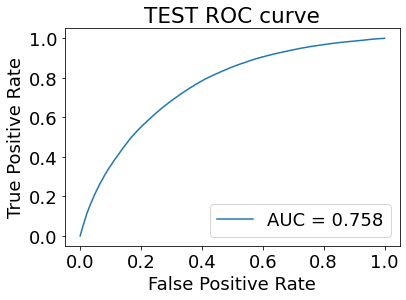

AUC: 0.758
Optimal threshold: 0.419
268875/268875 [==============================] - 92s 343us/sample - loss: 0.6353 - acc: 0.6910
-50
TEST
Mouse 4
(269025, 50, 31)


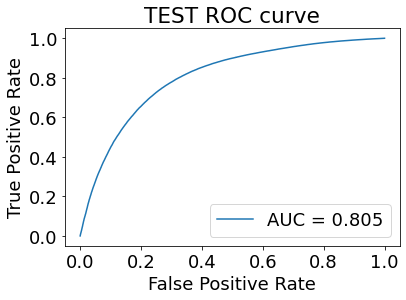

AUC: 0.805
Optimal threshold: 0.583
269025/269025 [==============================] - 92s 343us/sample - loss: 0.5618 - acc: 0.7483
-40
TEST
Mouse 4
(269175, 50, 31)


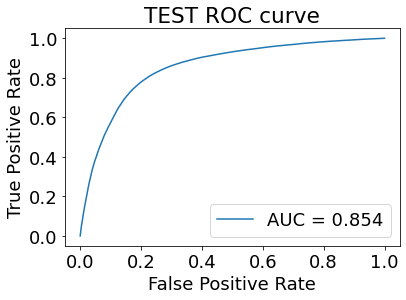

AUC: 0.854
Optimal threshold: 0.555
269175/269175 [==============================] - 92s 344us/sample - loss: 0.5063 - acc: 0.7949
-30
TEST
Mouse 4
(269325, 50, 31)


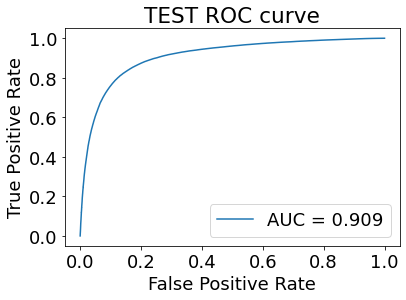

AUC: 0.909
Optimal threshold: 0.752
269325/269325 [==============================] - 92s 342us/sample - loss: 0.4101 - acc: 0.8384
-20
TEST
Mouse 4
(269475, 50, 31)


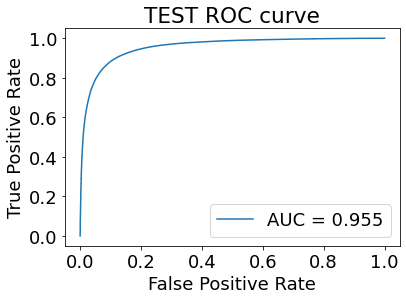

AUC: 0.955
Optimal threshold: 0.659
269475/269475 [==============================] - 92s 342us/sample - loss: 0.2722 - acc: 0.8926
-10
TEST
Mouse 4
(269550, 50, 31)


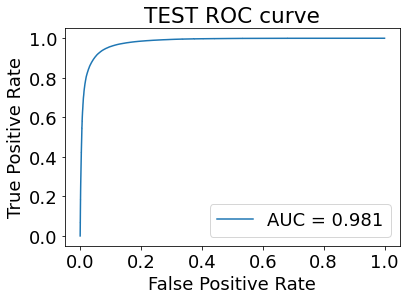

AUC: 0.981
Optimal threshold: 0.685
269550/269550 [==============================] - 89s 330us/sample - loss: 0.1748 - acc: 0.9327
0
TEST
Mouse 4
(269550, 50, 31)


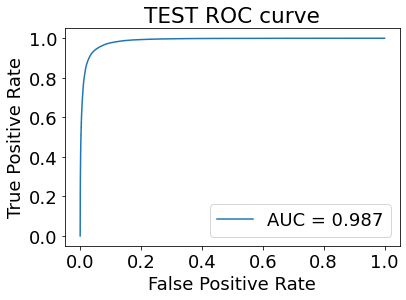

AUC: 0.987
Optimal threshold: 0.774
269550/269550 [==============================] - 93s 343us/sample - loss: 0.1470 - acc: 0.9460
10
TEST
Mouse 4
(269550, 50, 31)


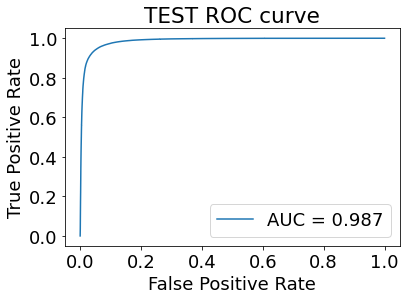

AUC: 0.987
Optimal threshold: 0.751
269550/269550 [==============================] - 92s 342us/sample - loss: 0.1512 - acc: 0.9440
20
TEST
Mouse 4
(269475, 50, 31)


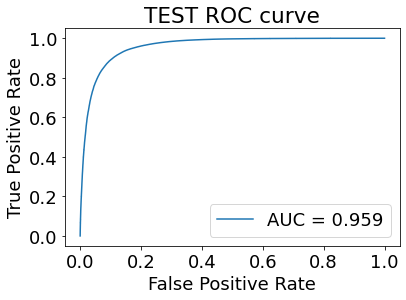

AUC: 0.959
Optimal threshold: 0.577
269475/269475 [==============================] - 92s 342us/sample - loss: 0.2527 - acc: 0.9013
30
TEST
Mouse 4
(269325, 50, 31)


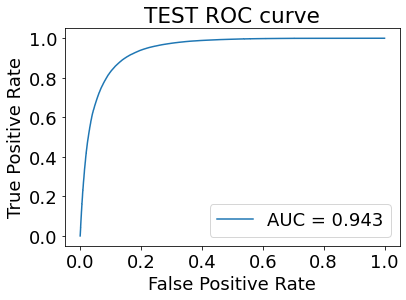

AUC: 0.943
Optimal threshold: 0.581
269325/269325 [==============================] - 93s 347us/sample - loss: 0.2914 - acc: 0.8825
40
TEST
Mouse 4
(269175, 50, 31)


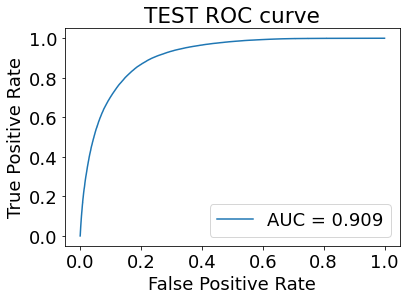

AUC: 0.909
Optimal threshold: 0.678
269175/269175 [==============================] - 93s 345us/sample - loss: 0.3764 - acc: 0.8392
50
TEST
Mouse 4
(269025, 50, 31)


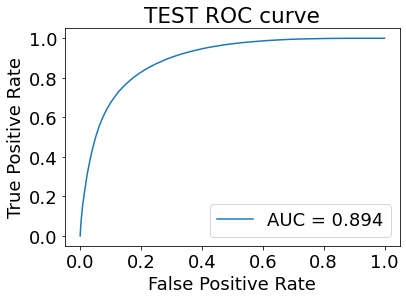

AUC: 0.894
Optimal threshold: 0.718
269025/269025 [==============================] - 94s 348us/sample - loss: 0.4292 - acc: 0.8191
60
TEST
Mouse 4
(268875, 50, 31)


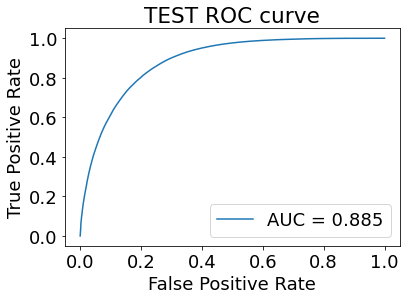

AUC: 0.885
Optimal threshold: 0.606
268875/268875 [==============================] - 93s 346us/sample - loss: 0.4183 - acc: 0.8172
-60
TEST
Mouse 4
(268875, 50, 31)


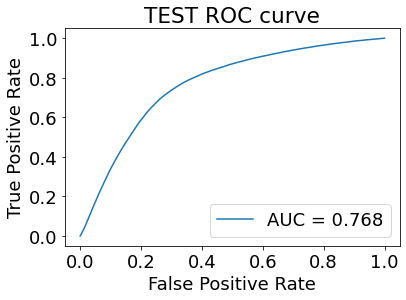

AUC: 0.768
Optimal threshold: 0.646
268875/268875 [==============================] - 94s 349us/sample - loss: 0.5998 - acc: 0.7269
-50
TEST
Mouse 4
(269025, 50, 31)


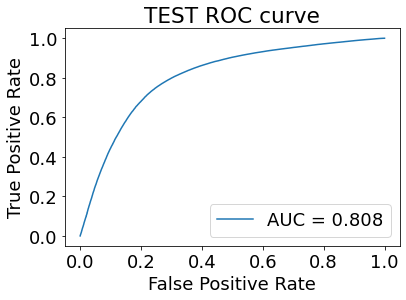

AUC: 0.808
Optimal threshold: 0.675
269025/269025 [==============================] - 94s 350us/sample - loss: 0.5675 - acc: 0.7557
-40
TEST
Mouse 4
(269175, 50, 31)


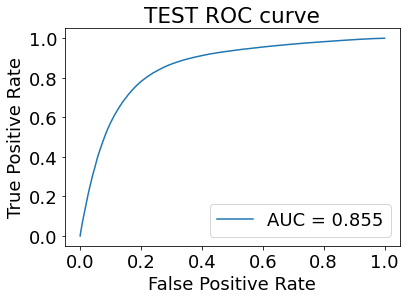

AUC: 0.855
Optimal threshold: 0.502
269175/269175 [==============================] - 94s 348us/sample - loss: 0.4843 - acc: 0.7970
-30
TEST
Mouse 4
(269325, 50, 31)


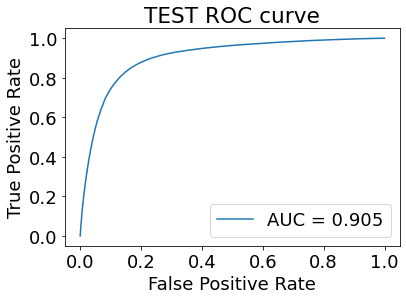

AUC: 0.905
Optimal threshold: 0.566
269325/269325 [==============================] - 92s 343us/sample - loss: 0.3953 - acc: 0.8451
-20
TEST
Mouse 4
(269475, 50, 31)


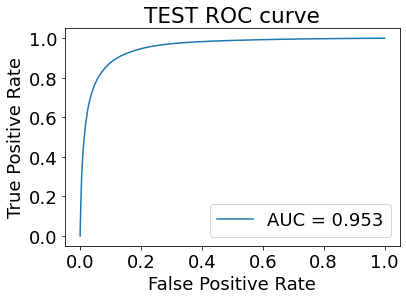

AUC: 0.953
Optimal threshold: 0.627
269475/269475 [==============================] - 95s 352us/sample - loss: 0.2808 - acc: 0.8919
-10
TEST
Mouse 4
(269550, 50, 31)


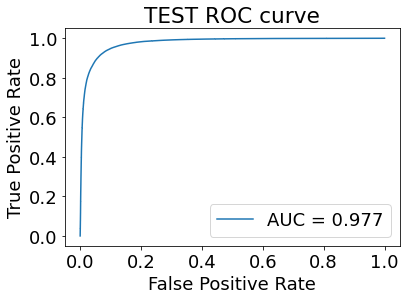

AUC: 0.977
Optimal threshold: 0.584
269550/269550 [==============================] - 96s 355us/sample - loss: 0.1959 - acc: 0.9278
0
TEST
Mouse 4
(269550, 50, 31)


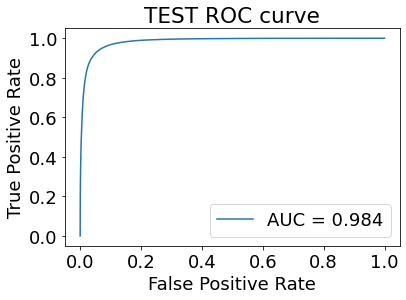

AUC: 0.984
Optimal threshold: 0.637
269550/269550 [==============================] - 96s 356us/sample - loss: 0.1593 - acc: 0.9408
10
TEST
Mouse 4
(269550, 50, 31)


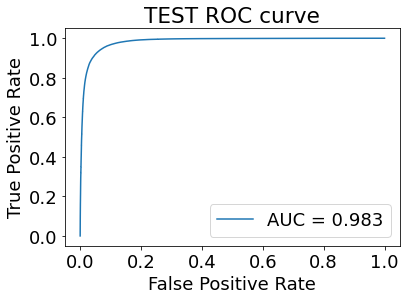

AUC: 0.983
Optimal threshold: 0.522
269550/269550 [==============================] - 95s 354us/sample - loss: 0.1643 - acc: 0.9389
20
TEST
Mouse 4
(269475, 50, 31)


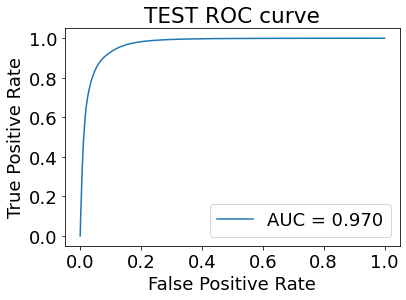

AUC: 0.970
Optimal threshold: 0.465
269475/269475 [==============================] - 93s 345us/sample - loss: 0.2126 - acc: 0.9170
30
TEST
Mouse 4
(269325, 50, 31)


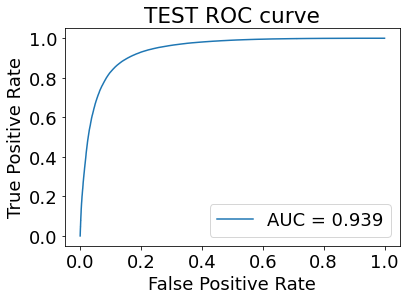

AUC: 0.939
Optimal threshold: 0.547
269325/269325 [==============================] - 96s 357us/sample - loss: 0.3233 - acc: 0.8761
40
TEST
Mouse 4
(269175, 50, 31)


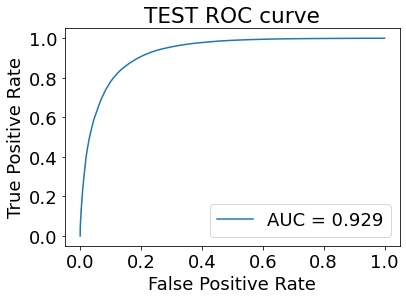

AUC: 0.929
Optimal threshold: 0.468
269175/269175 [==============================] - 96s 355us/sample - loss: 0.3510 - acc: 0.8568
50
TEST
Mouse 4
(269025, 50, 31)


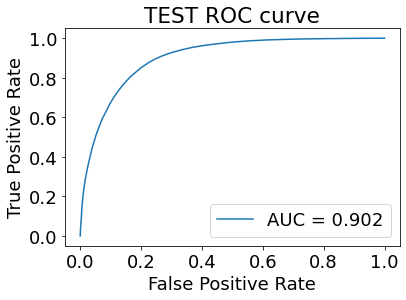

AUC: 0.902
Optimal threshold: 0.319
269025/269025 [==============================] - 96s 358us/sample - loss: 0.4435 - acc: 0.8189
60
TEST
Mouse 4
(268875, 50, 31)


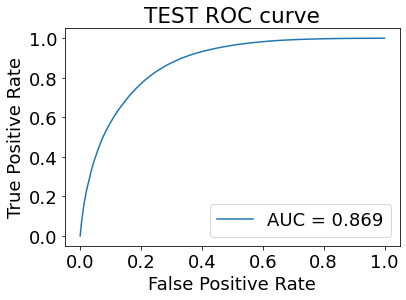

AUC: 0.869
Optimal threshold: 0.403
268875/268875 [==============================] - 97s 359us/sample - loss: 0.5110 - acc: 0.7877
-60
TEST
Mouse 4
(268875, 50, 31)


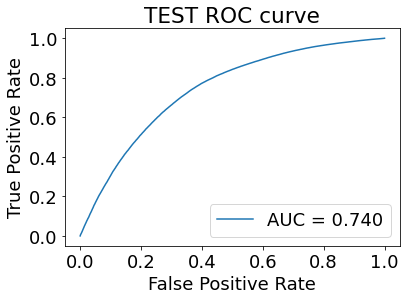

AUC: 0.740
Optimal threshold: 0.590
268875/268875 [==============================] - 93s 344us/sample - loss: 0.6115 - acc: 0.7015
-50
TEST
Mouse 4
(269025, 50, 31)


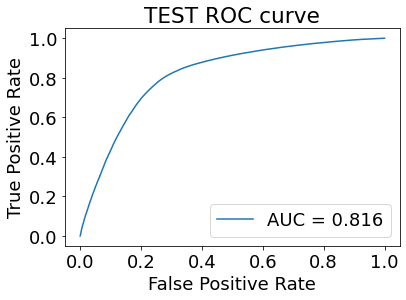

AUC: 0.816
Optimal threshold: 0.645
269025/269025 [==============================] - 98s 363us/sample - loss: 0.5365 - acc: 0.7701
-40
TEST
Mouse 4
(269175, 50, 31)


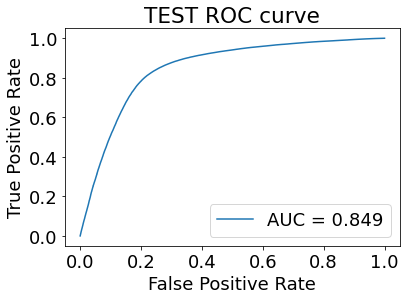

AUC: 0.849
Optimal threshold: 0.611
269175/269175 [==============================] - 98s 363us/sample - loss: 0.4867 - acc: 0.8041
-30
TEST
Mouse 4
(269325, 50, 31)


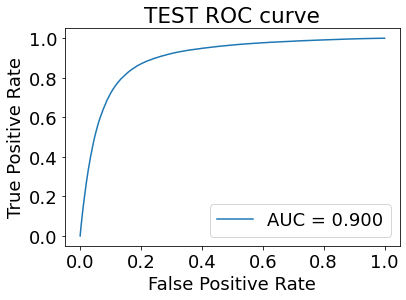

AUC: 0.900
Optimal threshold: 0.614
269325/269325 [==============================] - 98s 364us/sample - loss: 0.4046 - acc: 0.8403
-20
TEST
Mouse 4
(269475, 50, 31)


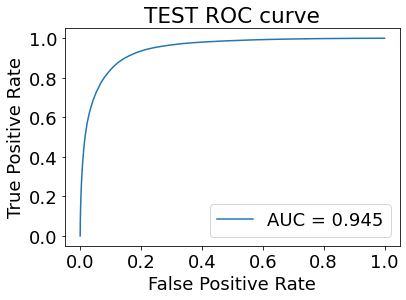

AUC: 0.945
Optimal threshold: 0.511
269475/269475 [==============================] - 98s 364us/sample - loss: 0.3039 - acc: 0.8799
-10
TEST
Mouse 4
(269550, 50, 31)


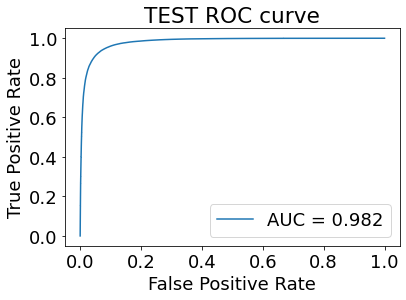

AUC: 0.982
Optimal threshold: 0.661
269550/269550 [==============================] - 95s 351us/sample - loss: 0.1726 - acc: 0.9352
0
TEST
Mouse 4
(269550, 50, 31)


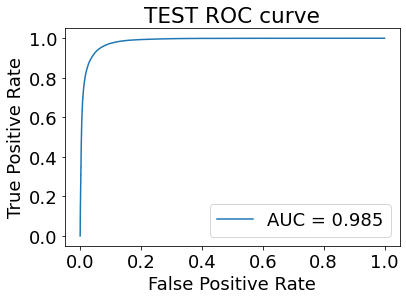

AUC: 0.985
Optimal threshold: 0.521
269550/269550 [==============================] - 99s 366us/sample - loss: 0.1481 - acc: 0.9444
10
TEST
Mouse 4
(269550, 50, 31)


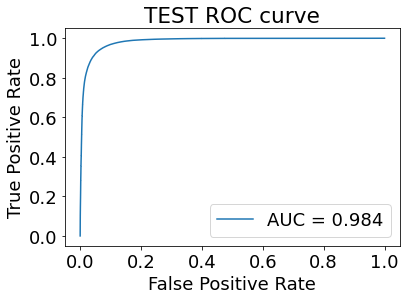

AUC: 0.984
Optimal threshold: 0.542
269550/269550 [==============================] - 99s 365us/sample - loss: 0.1562 - acc: 0.9404
20
TEST
Mouse 4
(269475, 50, 31)


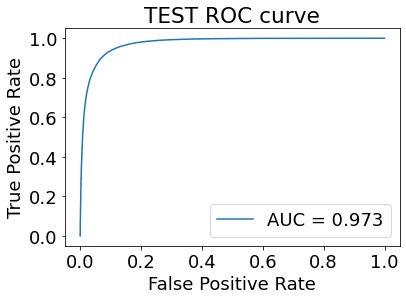

AUC: 0.973
Optimal threshold: 0.529
269475/269475 [==============================] - 98s 363us/sample - loss: 0.2044 - acc: 0.9210
30
TEST
Mouse 4
(269325, 50, 31)


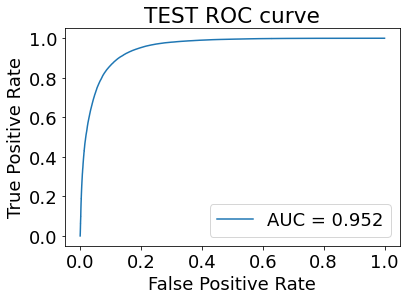

AUC: 0.952
Optimal threshold: 0.318
269325/269325 [==============================] - 99s 368us/sample - loss: 0.3188 - acc: 0.8713
40
TEST
Mouse 4
(269175, 50, 31)


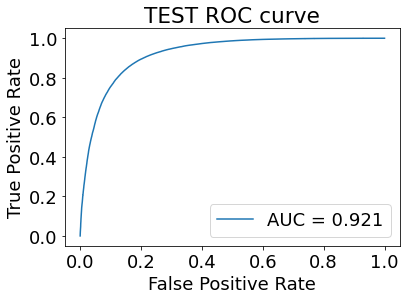

AUC: 0.921
Optimal threshold: 0.387
269175/269175 [==============================] - 99s 368us/sample - loss: 0.3840 - acc: 0.8444
50
TEST
Mouse 4
(269025, 50, 31)


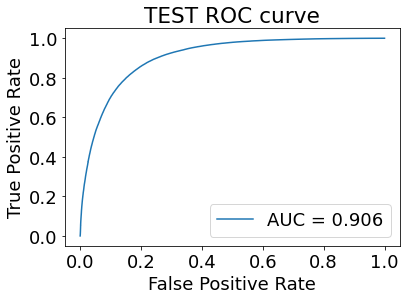

AUC: 0.906
Optimal threshold: 0.277
269025/269025 [==============================] - 99s 369us/sample - loss: 0.4744 - acc: 0.8087
60
TEST
Mouse 4
(268875, 50, 31)


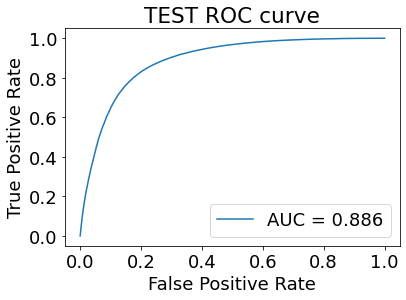

AUC: 0.886
Optimal threshold: 0.620
268875/268875 [==============================] - 99s 367us/sample - loss: 0.4333 - acc: 0.8215
-60
TEST
Mouse 5
(215100, 50, 31)


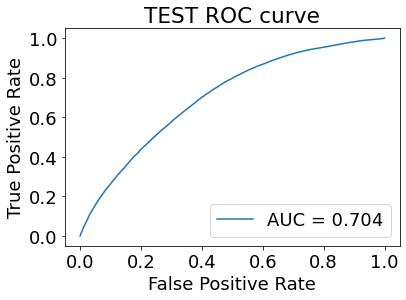

AUC: 0.704
Optimal threshold: 0.725
215100/215100 [==============================] - 81s 375us/sample - loss: 0.4864 - acc: 0.7950
-50
TEST
Mouse 5
(215220, 50, 31)


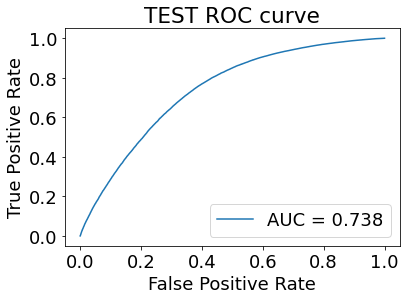

AUC: 0.738
Optimal threshold: 0.795
215220/215220 [==============================] - 80s 373us/sample - loss: 0.4471 - acc: 0.8134
-40
TEST
Mouse 5
(215340, 50, 31)


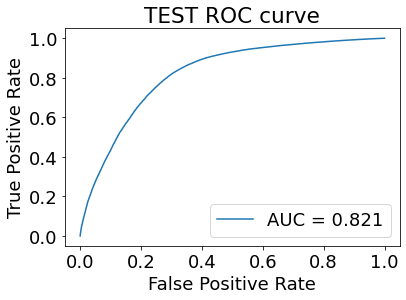

AUC: 0.821
Optimal threshold: 0.865
215340/215340 [==============================] - 81s 376us/sample - loss: 0.3915 - acc: 0.8458
-30
TEST
Mouse 5
(215460, 50, 31)


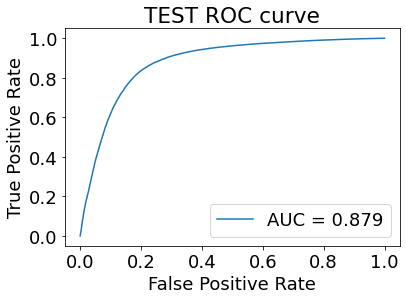

AUC: 0.879
Optimal threshold: 0.850
215460/215460 [==============================] - 79s 368us/sample - loss: 0.3340 - acc: 0.8757
-20
TEST
Mouse 5
(215580, 50, 31)


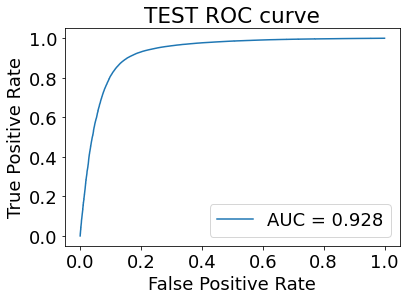

AUC: 0.928
Optimal threshold: 0.834
215580/215580 [==============================] - 81s 376us/sample - loss: 0.2463 - acc: 0.9099
-10
TEST
Mouse 5
(215640, 50, 31)


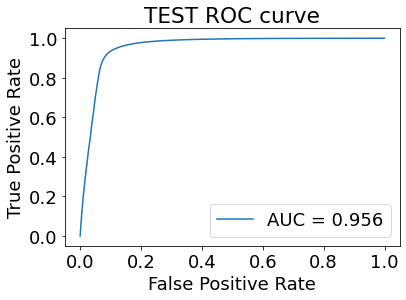

AUC: 0.956
Optimal threshold: 0.890
215640/215640 [==============================] - 81s 377us/sample - loss: 0.1857 - acc: 0.9402
0
TEST
Mouse 5
(215640, 50, 31)


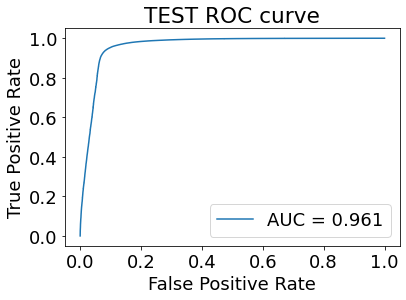

AUC: 0.961
Optimal threshold: 0.923
215640/215640 [==============================] - 82s 379us/sample - loss: 0.1754 - acc: 0.9421
10
TEST
Mouse 5
(215640, 50, 31)


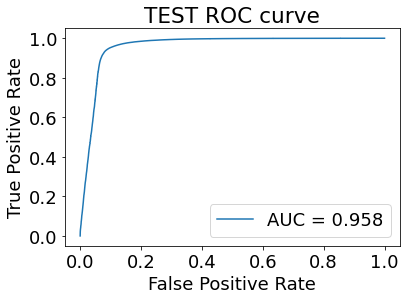

AUC: 0.958
Optimal threshold: 0.839
215640/215640 [==============================] - 81s 378us/sample - loss: 0.1628 - acc: 0.9505
20
TEST
Mouse 5
(215580, 50, 31)


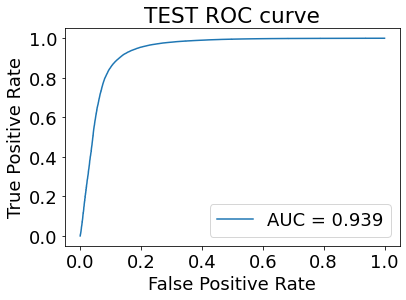

AUC: 0.939
Optimal threshold: 0.869
215580/215580 [==============================] - 82s 380us/sample - loss: 0.2226 - acc: 0.9235
30
TEST
Mouse 5
(215460, 50, 31)


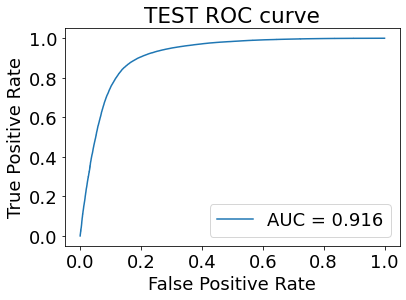

AUC: 0.916
Optimal threshold: 0.882
215460/215460 [==============================] - 82s 381us/sample - loss: 0.2712 - acc: 0.8978
40
TEST
Mouse 5
(215340, 50, 31)


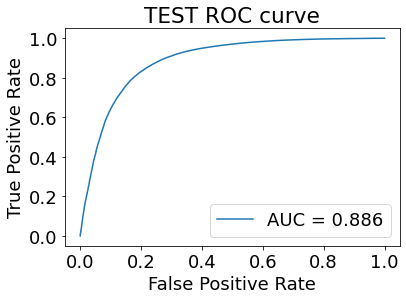

AUC: 0.886
Optimal threshold: 0.864
215340/215340 [==============================] - 82s 383us/sample - loss: 0.3164 - acc: 0.8746
50
TEST
Mouse 5
(215220, 50, 31)


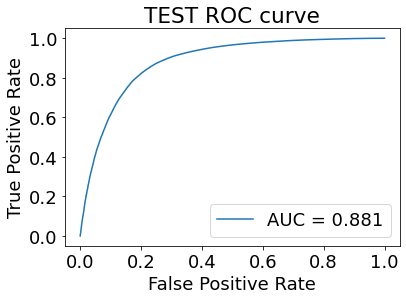

AUC: 0.881
Optimal threshold: 0.871
215220/215220 [==============================] - 82s 383us/sample - loss: 0.3292 - acc: 0.8683
60
TEST
Mouse 5
(215100, 50, 31)


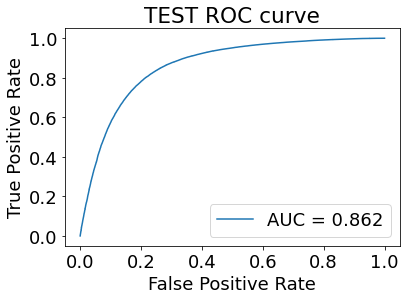

AUC: 0.862
Optimal threshold: 0.942
215100/215100 [==============================] - 82s 382us/sample - loss: 0.4120 - acc: 0.8450
-60
TEST
Mouse 5
(215100, 50, 31)


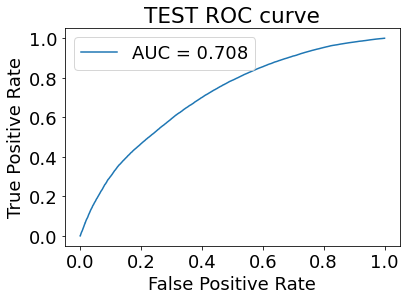

AUC: 0.708
Optimal threshold: 0.735
215100/215100 [==============================] - 83s 384us/sample - loss: 0.5308 - acc: 0.7667
-50
TEST
Mouse 5
(215220, 50, 31)


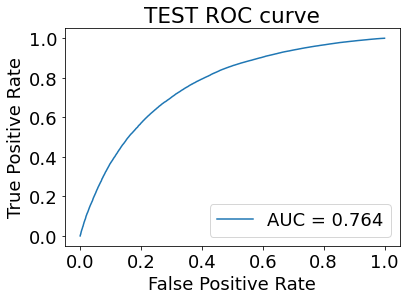

AUC: 0.764
Optimal threshold: 0.818
215220/215220 [==============================] - 81s 374us/sample - loss: 0.4464 - acc: 0.8088
-40
TEST
Mouse 5
(215340, 50, 31)


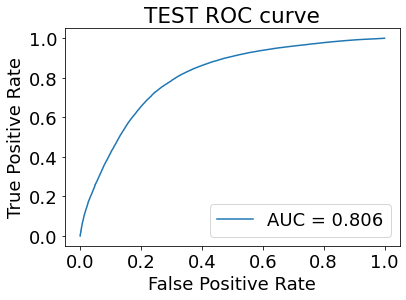

AUC: 0.806
Optimal threshold: 0.726
215340/215340 [==============================] - 81s 378us/sample - loss: 0.4093 - acc: 0.8281
-30
TEST
Mouse 5
(215460, 50, 31)


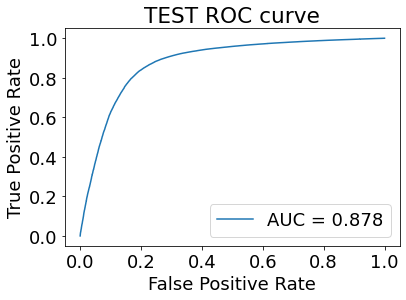

AUC: 0.878
Optimal threshold: 0.843
215460/215460 [==============================] - 81s 378us/sample - loss: 0.3296 - acc: 0.8734
-20
TEST
Mouse 5
(215580, 50, 31)


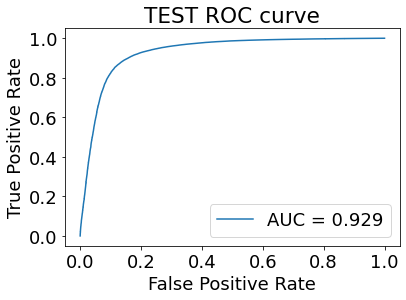

AUC: 0.929
Optimal threshold: 0.896
215580/215580 [==============================] - 82s 382us/sample - loss: 0.2551 - acc: 0.9066
-10
TEST
Mouse 5
(215640, 50, 31)


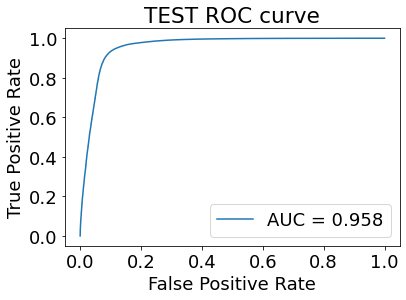

AUC: 0.958
Optimal threshold: 0.881
215640/215640 [==============================] - 82s 380us/sample - loss: 0.1792 - acc: 0.9421
0
TEST
Mouse 5
(215640, 50, 31)


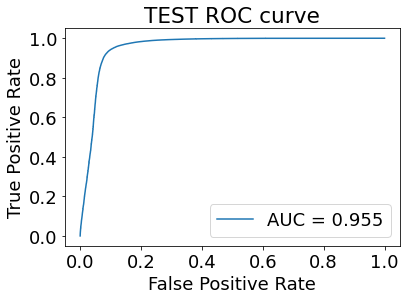

AUC: 0.955
Optimal threshold: 0.846
215640/215640 [==============================] - 82s 382us/sample - loss: 0.1665 - acc: 0.9480
10
TEST
Mouse 5
(215640, 50, 31)


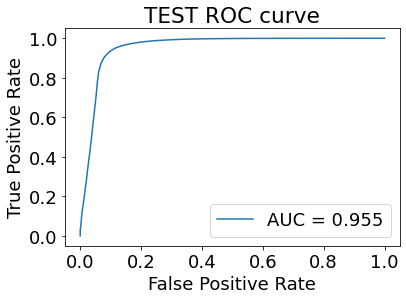

AUC: 0.955
Optimal threshold: 0.884
215640/215640 [==============================] - 83s 383us/sample - loss: 0.1827 - acc: 0.9417
20
TEST
Mouse 5
(215580, 50, 31)


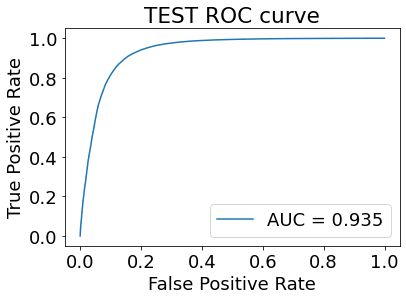

AUC: 0.935
Optimal threshold: 0.890
215580/215580 [==============================] - 82s 380us/sample - loss: 0.2447 - acc: 0.9103
30
TEST
Mouse 5
(215460, 50, 31)


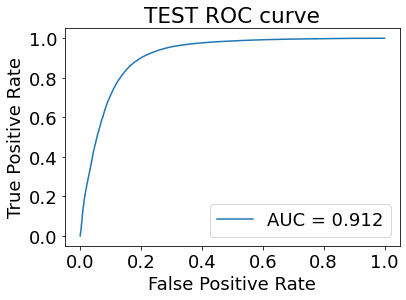

AUC: 0.912
Optimal threshold: 0.919
215460/215460 [==============================] - 82s 383us/sample - loss: 0.3132 - acc: 0.8810
40
TEST
Mouse 5
(215340, 50, 31)


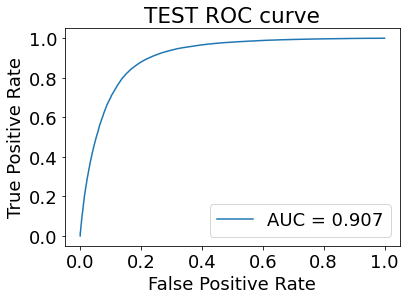

AUC: 0.907
Optimal threshold: 0.933
215340/215340 [==============================] - 83s 386us/sample - loss: 0.3297 - acc: 0.8761
50
TEST
Mouse 5
(215220, 50, 31)


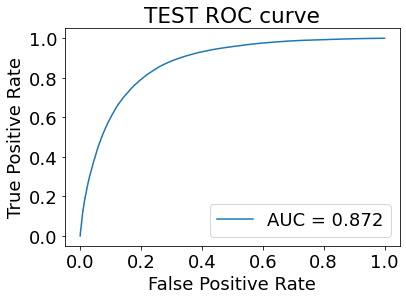

AUC: 0.872
Optimal threshold: 0.875
215220/215220 [==============================] - 83s 384us/sample - loss: 0.3421 - acc: 0.8667
60
TEST
Mouse 5
(215100, 50, 31)


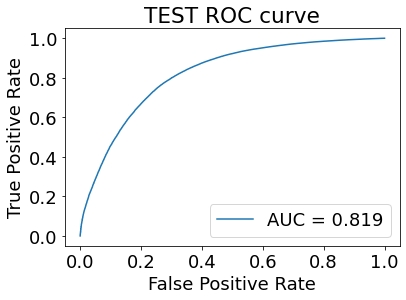

AUC: 0.819
Optimal threshold: 0.888
215100/215100 [==============================] - 83s 386us/sample - loss: 0.4026 - acc: 0.8418
-60
TEST
Mouse 5
(215100, 50, 31)


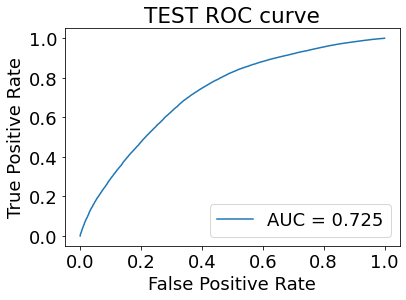

AUC: 0.725
Optimal threshold: 0.671
215100/215100 [==============================] - 84s 389us/sample - loss: 0.5169 - acc: 0.7778
-50
TEST
Mouse 5
(215220, 50, 31)


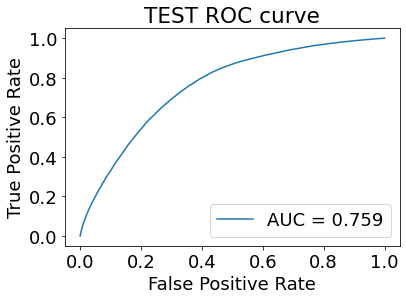

AUC: 0.759
Optimal threshold: 0.715
215220/215220 [==============================] - 83s 387us/sample - loss: 0.4659 - acc: 0.8055
-40
TEST
Mouse 5
(215340, 50, 31)


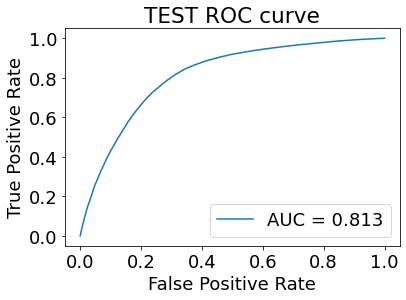

AUC: 0.813
Optimal threshold: 0.718
215340/215340 [==============================] - 84s 392us/sample - loss: 0.4201 - acc: 0.8334
-30
TEST
Mouse 5
(215460, 50, 31)


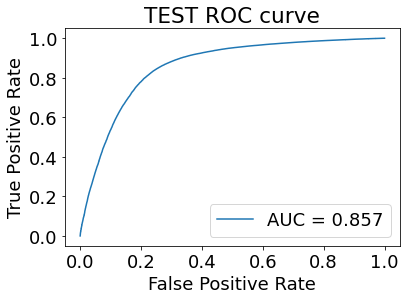

AUC: 0.857
Optimal threshold: 0.675
215460/215460 [==============================] - 85s 396us/sample - loss: 0.3714 - acc: 0.8571
-20
TEST
Mouse 5
(215580, 50, 31)


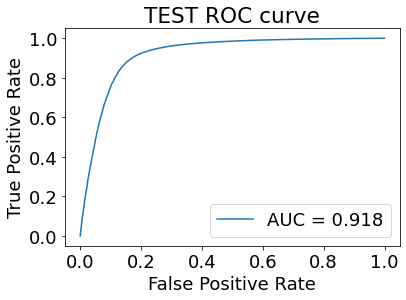

AUC: 0.918
Optimal threshold: 0.752
215580/215580 [==============================] - 89s 411us/sample - loss: 0.2606 - acc: 0.9091
-10
TEST
Mouse 5
(215640, 50, 31)


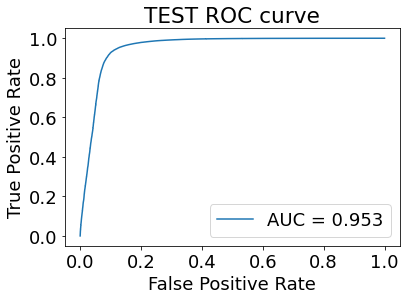

AUC: 0.953
Optimal threshold: 0.747
215640/215640 [==============================] - 88s 410us/sample - loss: 0.1782 - acc: 0.9432
0
TEST
Mouse 5
(215640, 50, 31)


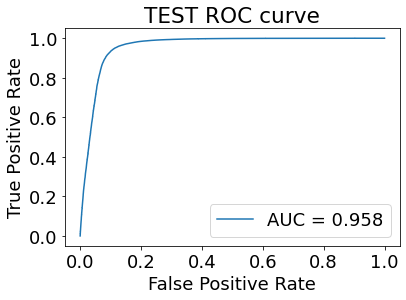

AUC: 0.958
Optimal threshold: 0.739
215640/215640 [==============================] - 88s 409us/sample - loss: 0.1659 - acc: 0.9481
10
TEST
Mouse 5
(215640, 50, 31)


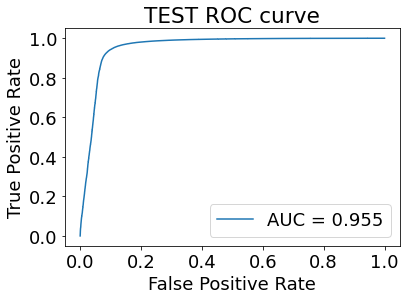

AUC: 0.955
Optimal threshold: 0.886
215640/215640 [==============================] - 89s 413us/sample - loss: 0.1757 - acc: 0.9457
20
TEST
Mouse 5
(215580, 50, 31)


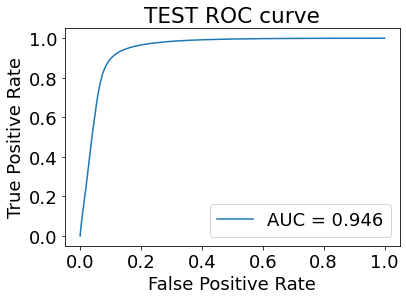

AUC: 0.946
Optimal threshold: 0.897
215580/215580 [==============================] - 89s 413us/sample - loss: 0.2073 - acc: 0.9302
30
TEST
Mouse 5
(215460, 50, 31)


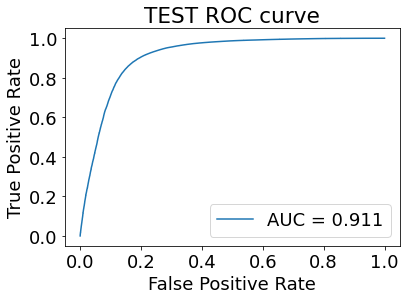

AUC: 0.911
Optimal threshold: 0.890
215460/215460 [==============================] - 89s 412us/sample - loss: 0.2785 - acc: 0.8988
40
TEST
Mouse 5
(215340, 50, 31)


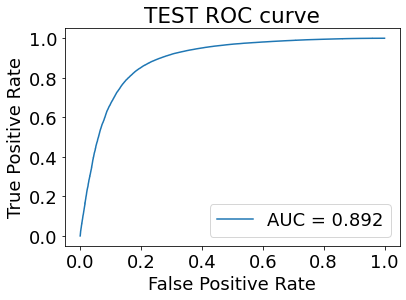

AUC: 0.892
Optimal threshold: 0.922
215340/215340 [==============================] - 90s 417us/sample - loss: 0.3388 - acc: 0.8699
50
TEST
Mouse 5
(215220, 50, 31)


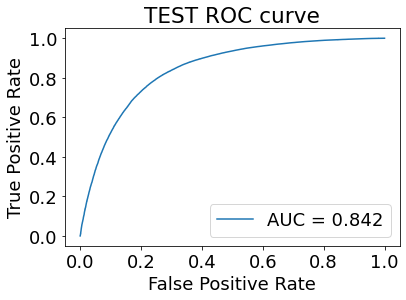

AUC: 0.842
Optimal threshold: 0.935
215220/215220 [==============================] - 89s 412us/sample - loss: 0.4274 - acc: 0.8348
60
TEST
Mouse 5
(215100, 50, 31)


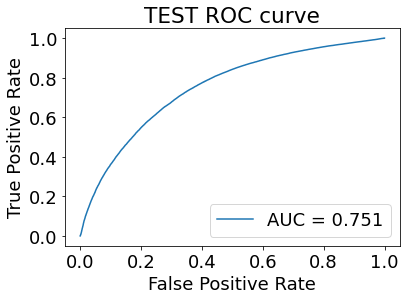

AUC: 0.751
Optimal threshold: 0.942
215100/215100 [==============================] - 91s 423us/sample - loss: 0.5232 - acc: 0.8080
-60
TEST
Mouse 5
(215100, 50, 31)


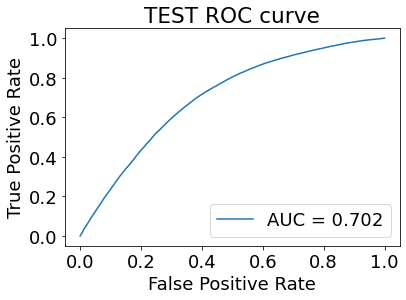

AUC: 0.702
Optimal threshold: 0.820
215100/215100 [==============================] - 86s 401us/sample - loss: 0.5052 - acc: 0.7894
-50
TEST
Mouse 5
(215220, 50, 31)


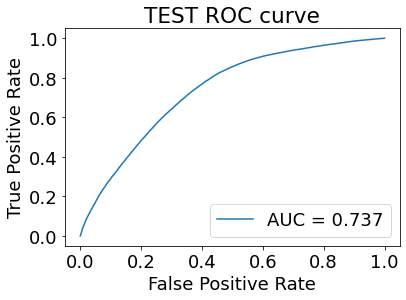

AUC: 0.737
Optimal threshold: 0.801
215220/215220 [==============================] - 87s 402us/sample - loss: 0.4698 - acc: 0.8117
-40
TEST
Mouse 5
(215340, 50, 31)


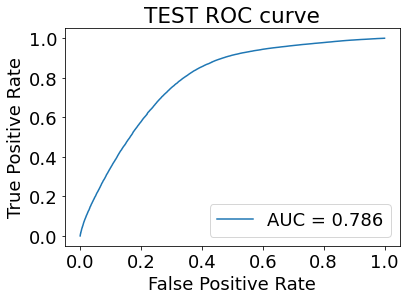

AUC: 0.786
Optimal threshold: 0.785
215340/215340 [==============================] - 87s 405us/sample - loss: 0.4085 - acc: 0.8370
-30
TEST
Mouse 5
(215460, 50, 31)


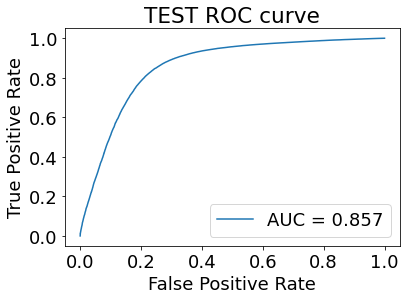

AUC: 0.857
Optimal threshold: 0.866
215460/215460 [==============================] - 88s 406us/sample - loss: 0.3479 - acc: 0.8668
-20
TEST
Mouse 5
(215580, 50, 31)


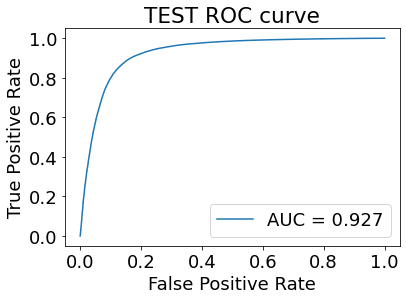

AUC: 0.927
Optimal threshold: 0.866
215580/215580 [==============================] - 88s 406us/sample - loss: 0.2550 - acc: 0.9078
-10
TEST
Mouse 5
(215640, 50, 31)


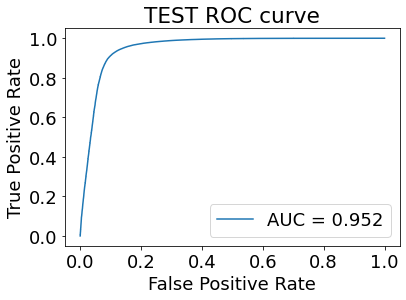

AUC: 0.952
Optimal threshold: 0.862
215640/215640 [==============================] - 88s 410us/sample - loss: 0.1907 - acc: 0.9368
0
TEST
Mouse 5
(215640, 50, 31)


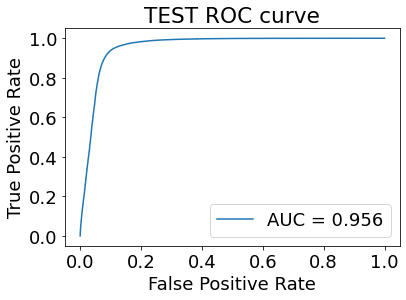

AUC: 0.956
Optimal threshold: 0.803
215640/215640 [==============================] - 88s 407us/sample - loss: 0.1661 - acc: 0.9473
10
TEST
Mouse 5
(215640, 50, 31)


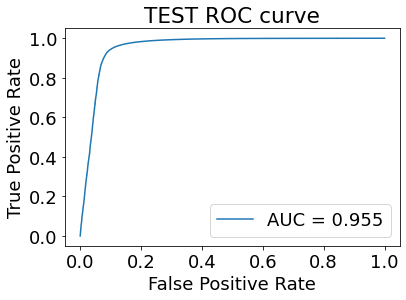

AUC: 0.955
Optimal threshold: 0.834
215640/215640 [==============================] - 88s 408us/sample - loss: 0.1674 - acc: 0.9475
20
TEST
Mouse 5
(215580, 50, 31)


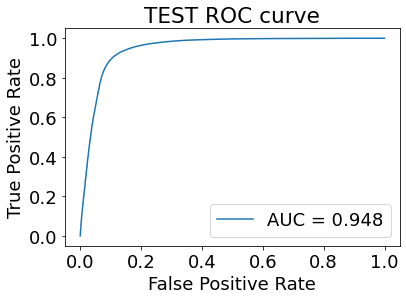

AUC: 0.948
Optimal threshold: 0.843
215580/215580 [==============================] - 88s 407us/sample - loss: 0.1958 - acc: 0.9311
30
TEST
Mouse 5
(215460, 50, 31)


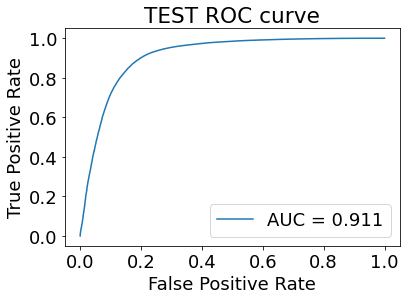

AUC: 0.911
Optimal threshold: 0.885
215460/215460 [==============================] - 88s 407us/sample - loss: 0.2824 - acc: 0.8948
40
TEST
Mouse 5
(215340, 50, 31)


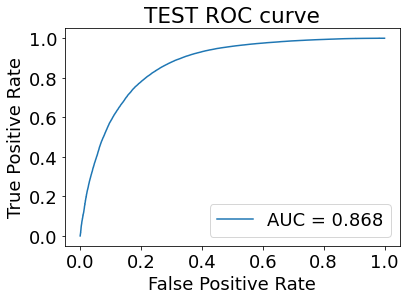

AUC: 0.868
Optimal threshold: 0.883
215340/215340 [==============================] - 88s 410us/sample - loss: 0.3459 - acc: 0.8615
50
TEST
Mouse 5
(215220, 50, 31)


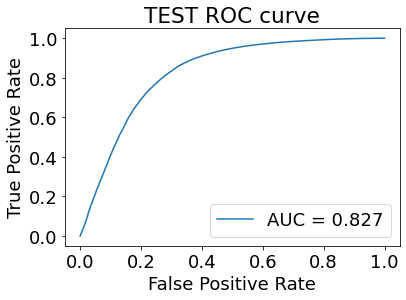

AUC: 0.827
Optimal threshold: 0.900
215220/215220 [==============================] - 89s 412us/sample - loss: 0.4014 - acc: 0.8498
60
TEST
Mouse 5
(215100, 50, 31)


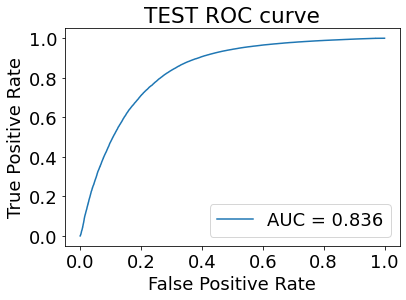

AUC: 0.836
Optimal threshold: 0.870
215100/215100 [==============================] - 88s 411us/sample - loss: 0.3833 - acc: 0.8552


In [14]:
l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    for shift_frame in WinShift:
        print(shift_frame)
        testX, testY = Get_Dataset(TEST, shift_frame)
        print(testX.shape)
        input_test = testX.transpose(0,2,1)
        ver = f'{ModelType}_{VALID}_{TEST}_shift{shift_frame}'
        model_file_path = f'./models_N20_WindowShift/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        df_AUC[shift_frame][raw] = plot_roc(test_pred, testY, "TEST")
        results = model.evaluate(input_test,testY)
        df_LOSS[shift_frame][raw] = results[0]
        df_ACC[shift_frame][raw] = results[1]

In [15]:
df_AUC.to_csv('N20_WindowShift_result_AUC.csv')
df_AUC

VALID  TEST       -60       -50       -40       -30       -20       -10  \
0     2.0   1.0  0.786993  0.757366  0.838200  0.823675  0.861217  0.916003   
1     3.0   1.0  0.697952  0.749496  0.775892  0.812855  0.841005  0.890044   
2     4.0   1.0  0.761988  0.785296  0.810881  0.843526  0.860537  0.924324   
3     5.0   1.0  0.699294  0.798336  0.844026  0.863742  0.884820  0.929665   
4     1.0   2.0  0.743908  0.810520  0.763968  0.922878  0.955675  0.976075   
5     3.0   2.0  0.752765  0.769425  0.826786  0.908922  0.949679  0.972742   
6     4.0   2.0  0.711263  0.792652  0.877160  0.880386  0.942694  0.974756   
7     5.0   2.0  0.799584  0.809006  0.806076  0.912409  0.951494  0.977847   
8     1.0   3.0  0.751472  0.834283  0.857273  0.913467  0.954359  0.975477   
9     2.0   3.0  0.742829  0.791986  0.842456  0.901822  0.960214  0.980047   
10    4.0   3.0  0.761700  0.816375  0.860756  0.906960  0.952110  0.977658   
11    5.0   3.0  0.784595  0.837221  0.862357  0.913529  0.959303  0.980464   
12    1.0   4.0  0.762505  0.816910  0.866160  0.884907  0.955419  0.981579   
13    2.0   4.0  0.757514  0.804873  0.853686  0.908531  0.955271  0.980763   
14    3.0   4.0  0.767576  0.807940  0.854753  0.904550  0.953014  0.976980   
15    5.0   4.0  0.740388  0.816274  0.848999  0.900488  0.945248  0.981534   
16    1.0   5.0  0.703708  0.738223  0.821198  0.878851  0.928295  0.955913   
17    2.0   5.0  0.708269  0.763611  0.806246  0.878287  0.929276  0.957570   
18    3.0   5.0  0.725080  0.759080  0.812621  0.857403  0.918347  0.952792   
19    4.0   5.0  0.702156  0.736942  0.786362  0.857023  0.926612  0.951981   

           0        10        20        30        40        50        60  
0   0.958076  0.961031  0.934119  0.878299  0.896617  0.883546  0.806126  
1   0.955052  0.957220  0.931291  0.918207  0.881169  0.851622  0.790849  
2   0.960126  0.955959  0.937058  0.890434  0.862875  0.878275  0.820248  
3   0.958905  0.966628  0.952485  0.914948  0.896407  0.896612  0.889996  
4   0.986540  0.980553  0.972064  0.889999  0.839697  0.830478  0.721501  
5   0.985850  0.983888  0.971504  0.929765  0.882023  0.841001  0.770304  
6   0.981014  0.983248  0.930095  0.899217  0.868659  0.824559  0.820953  
7   0.982591  0.981680  0.937334  0.888039  0.886235  0.852841  0.798497  
8   0.983654  0.985209  0.976579  0.947937  0.902677  0.797629  0.820535  
9   0.983640  0.984945  0.971062  0.945726  0.874199  0.824135  0.819093  
10  0.981442  0.979001  0.971382  0.932606  0.882558  0.797152  0.825898  
11  0.984562  0.985762  0.973086  0.941026  0.915092  0.881109  0.834184  
12  0.987468  0.987088  0.973650  0.944178  0.923385  0.896609  0.875049  
13  0.987281  0.986557  0.958597  0.942620  0.909422  0.893635  0.884595  
14  0.983669  0.983136  0.970329  0.938911  0.928884  0.902106  0.869151  
15  0.985316  0.983976  0.973361  0.952150  0.921270  0.905621  0.886468  
16  0.961119  0.958441  0.938572  0.915546  0.886166  0.880756  0.861969  
17  0.954972  0.954993  0.935450  0.912372  0.906535  0.871883  0.819265  
18  0.957715  0.954997  0.945874  0.911460  0.891872  0.842421  0.750525  
19  0.956418  0.955466  0.948002  0.910939  0.867502  0.827449  0.836112

In [16]:
df_LOSS.to_csv('N20_WindowShift_result_BCEloss.csv')
df_LOSS

VALID  TEST       -60       -50       -40       -30       -20       -10  \
0     2.0   1.0  0.599669  0.570742  0.486559  0.508477  0.476259  0.447590   
1     3.0   1.0  0.627583  0.582339  0.582042  0.530945  0.536116  0.482453   
2     4.0   1.0  0.584003  0.539354  0.513687  0.502316  0.458821  0.413064   
3     5.0   1.0  0.708735  0.534870  0.485719  0.445785  0.469206  0.474113   
4     1.0   2.0  0.580995  0.545491  0.759287  0.353443  0.265820  0.187183   
5     3.0   2.0  0.619390  0.598159  0.529280  0.402504  0.330866  0.247112   
6     4.0   2.0  0.613863  0.519021  0.409720  0.462965  0.348941  0.208045   
7     5.0   2.0  0.580649  0.544390  0.591460  0.413117  0.367499  0.207346   
8     1.0   3.0  0.562174  0.478147  0.467393  0.350593  0.251954  0.189848   
9     2.0   3.0  0.568575  0.539912  0.457256  0.373728  0.244220  0.175807   
10    4.0   3.0  0.552903  0.502032  0.447091  0.368629  0.268736  0.175783   
11    5.0   3.0  0.534823  0.483292  0.433805  0.351429  0.240630  0.161718   
12    1.0   4.0  0.604729  0.548769  0.490614  0.446196  0.280890  0.181779   
13    2.0   4.0  0.635338  0.561813  0.506274  0.410127  0.272232  0.174833   
14    3.0   4.0  0.599814  0.567496  0.484334  0.395274  0.280833  0.195900   
15    5.0   4.0  0.611481  0.536516  0.486673  0.404567  0.303870  0.172643   
16    1.0   5.0  0.486385  0.447106  0.391486  0.333956  0.246275  0.185738   
17    2.0   5.0  0.530765  0.446410  0.409280  0.329609  0.255132  0.179170   
18    3.0   5.0  0.516868  0.465889  0.420118  0.371376  0.260577  0.178212   
19    4.0   5.0  0.505189  0.469762  0.408462  0.347924  0.254965  0.190737   

           0        10        20        30        40        50        60  
0   0.255329  0.276332  0.319754  0.467950  0.467289  0.444354  0.875577  
1   0.336411  0.313328  0.353663  0.381278  0.445566  0.674775  0.758963  
2   0.326430  0.295474  0.322947  0.432081  0.490650  0.538880  0.702751  
3   0.344918  0.236750  0.275586  0.386135  0.438440  0.414934  0.444350  
4   0.144285  0.160630  0.200287  0.409931  0.647738  0.676294  0.728854  
5   0.162489  0.174615  0.199524  0.391578  0.513576  0.565195  0.700402  
6   0.194369  0.158854  0.383327  0.585282  0.610233  0.749737  0.647102  
7   0.171304  0.174262  0.439038  0.642275  0.469617  0.559303  0.808258  
8   0.149898  0.148509  0.189448  0.283697  0.399543  0.709217  0.576422  
9   0.147848  0.140693  0.205600  0.285235  0.440286  0.580472  0.624054  
10  0.157971  0.177797  0.189409  0.321018  0.435126  0.619217  0.562306  
11  0.138461  0.140993  0.231148  0.398795  0.512773  1.031266  0.726680  
12  0.150748  0.147844  0.207354  0.303553  0.367173  0.498008  0.562992  
13  0.147031  0.151241  0.252686  0.291417  0.376375  0.429189  0.418342  
14  0.159264  0.164317  0.212603  0.323313  0.351040  0.443492  0.510984  
15  0.148081  0.156152  0.204427  0.318760  0.383987  0.474415  0.433262  
16  0.175445  0.162810  0.222586  0.271173  0.316430  0.329160  0.412044  
17  0.166484  0.182703  0.244732  0.313151  0.329703  0.342056  0.402580  
18  0.165882  0.175694  0.207272  0.278523  0.338773  0.427412  0.523152  
19  0.166146  0.167354  0.195814  0.282415  0.345916  0.401409  0.383330

In [17]:
df_ACC.to_csv('N20_WindowShift_result_Accuracy.csv')
df_ACC

VALID  TEST       -60       -50       -40       -30       -20       -10  \
0     2.0   1.0  0.696260  0.718220  0.783591  0.767429  0.788791  0.812511   
1     3.0   1.0  0.669877  0.714479  0.721827  0.753971  0.771880  0.806162   
2     4.0   1.0  0.717454  0.736052  0.763479  0.772811  0.795501  0.836085   
3     5.0   1.0  0.606050  0.748491  0.780243  0.803256  0.785143  0.808818   
4     1.0   2.0  0.695867  0.726745  0.621923  0.876237  0.909110  0.933403   
5     3.0   2.0  0.700530  0.712871  0.749317  0.832201  0.861722  0.907313   
6     4.0   2.0  0.691390  0.759246  0.833189  0.800181  0.855937  0.923289   
7     5.0   2.0  0.713147  0.739220  0.701728  0.822218  0.841544  0.923845   
8     1.0   3.0  0.727288  0.791035  0.811718  0.865231  0.907073  0.928134   
9     2.0   3.0  0.724535  0.759222  0.806249  0.854028  0.909972  0.935130   
10    4.0   3.0  0.732927  0.771843  0.807149  0.853813  0.896923  0.934554   
11    5.0   3.0  0.744885  0.785957  0.818716  0.862883  0.913498  0.942372   
12    1.0   4.0  0.712547  0.767044  0.804465  0.820908  0.892038  0.930796   
13    2.0   4.0  0.690983  0.748321  0.794858  0.838377  0.892565  0.932699   
14    3.0   4.0  0.726925  0.755718  0.796995  0.845102  0.891871  0.927783   
15    5.0   4.0  0.701456  0.770118  0.804105  0.840290  0.879933  0.935237   
16    1.0   5.0  0.794965  0.813437  0.845839  0.875680  0.909890  0.940234   
17    2.0   5.0  0.766713  0.808786  0.828128  0.873401  0.906633  0.942126   
18    3.0   5.0  0.777759  0.805506  0.833417  0.857148  0.909115  0.943192   
19    4.0   5.0  0.789433  0.811653  0.837011  0.866769  0.907844  0.936797   

           0        10        20        30        40        50        60  
0   0.891395  0.881312  0.862500  0.797706  0.804240  0.797126  0.633529  
1   0.853119  0.866743  0.849556  0.836819  0.805466  0.732995  0.628178  
2   0.855937  0.869616  0.861266  0.811514  0.782386  0.781235  0.701646  
3   0.852390  0.901442  0.882347  0.825858  0.804012  0.817695  0.812583  
4   0.948456  0.944644  0.924775  0.821512  0.698918  0.718311  0.655072  
5   0.940442  0.933250  0.924014  0.846760  0.785131  0.753383  0.674193  
6   0.923933  0.939858  0.837077  0.762875  0.746359  0.707801  0.735509  
7   0.935318  0.934321  0.820619  0.740523  0.793053  0.754163  0.686271  
8   0.949229  0.947365  0.927748  0.881028  0.834088  0.731889  0.770667  
9   0.947118  0.951069  0.927259  0.890098  0.812968  0.776017  0.769596  
10  0.944753  0.937400  0.931987  0.872694  0.808928  0.761400  0.778394  
11  0.952918  0.948943  0.914325  0.847158  0.802364  0.679043  0.698243  
12  0.945617  0.943710  0.918831  0.879911  0.852386  0.794395  0.760357  
13  0.945988  0.943984  0.901264  0.882517  0.839238  0.819102  0.817179  
14  0.940790  0.938902  0.917050  0.876146  0.856773  0.818890  0.787701  
15  0.944389  0.940364  0.921013  0.871267  0.844387  0.808746  0.821452  
16  0.942052  0.950459  0.923476  0.897809  0.874622  0.868349  0.844979  
17  0.948001  0.941694  0.910340  0.880999  0.876061  0.866662  0.841818  
18  0.948066  0.945743  0.930207  0.898775  0.869908  0.834783  0.808043  
19  0.947287  0.947473  0.931139  0.894774  0.861535  0.849833  0.855207